### Online Shoppers Purchasing Intention (Classification CS)

This is a machine learning case study that I built to strengthen the techniques I’ve been learning.
I worked with the Online Shoppers Purchasing Intention Dataset from the UCI Machine Learning Repository:
https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

My main goal is to predict whether an online browsing session will end with a purchase, using detailed click-stream style behavioral features collected from an e-commerce website.

I approached this case exactly as I prefer to work in real ML projects:
start from the raw dataset, build a clean and reproducible feature pipeline, handle skewed numeric features, encode categorical variables properly, and then compare several models through business-relevant metrics rather than chasing a single score in isolation.

The entire workflow,data understanding, feature engineering, modeling, and evaluation was designed and implemented by me, following a structure that reflects how I would approach similar problems in production settings.

### 1. Problem definition and business framing
The dataset represents user sessions on an online store. For each session we know:

**How many pages of each type were visited (administrative, informational, product pages)**,

**How long the user spent on each type of page**,

**Bounce / exit rates and page value signals**,

**Technical context (browser, operating system, region, traffic source)**,

**Seasonality signals (month, weekend or not)**,

And finally **a binary label Revenue** indicating whether the session ended with a transaction.

#### From a business point of view:

**Positive class (Revenue = True)** ≈ 15% of all sessions. The data is mildly imbalanced: most visitors do not buy.

A realistic model will never be perfect. **The real question is**:

**How many buying visitors can we catch early (recall)?**

**How many of the users we flag as “likely buyers” actually buy (precision)?**

The target use case is a typical “next-best-action” scenario:

Prioritize high-intent users for remarketing or sales campaigns,

Trigger personalized offers or dynamic pricing for sessions with high purchase probability,

Measure uplift in a controlled experiment, using the model as a decision engine.

This framing naturally pushes us towards recall and F1-score as the main metrics, with ROC-AUC as a stability check.

In [95]:
!pip install ucimlrepo --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)

%matplotlib inline
pd.set_option("display.max_columns", 50)

In [96]:
#Fetch the dataset from the UCI repository
online_shoppers = fetch_ucirepo(id=468)

online_shoppers = fetch_ucirepo(id=468)

X = online_shoppers.data.features      # features
y = online_shoppers.data.targets.squeeze()   # target

In [23]:
X.head()
X.info()
X.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330,12330.000000,12330.000000,12330.000000,12330.000000,12330,12330
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,3,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May,NaN,NaN,NaN,NaN,Returning_Visitor,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3364,NaN,NaN,NaN,NaN,10551,9462
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,NaN,2.124006,2.357097,3.147364,4.069586,NaN,NaN
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,NaN,0.911325,1.717277,2.401591,4.025169,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,NaN,2.000000,2.000000,1.000000,2.000000,NaN,NaN
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,NaN,2.000000,2.000000,3.000000,2.000000,NaN,NaN
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,NaN,3.000000,2.000000,4.000000,4.000000,NaN,NaN


In [24]:
print (y.head())

0    False
1    False
2    False
3    False
4    False
Name: Revenue, dtype: bool


##### Now I will examine the target variable on its own

In [25]:
y.value_counts(normalize=True)

Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64

As we can see through the distribution of the target variable: there is class imbalance (≈ 85% False, 15% True). This finding is critical; it makes the model biased

In [97]:
categorical_cols = ['Month', 'VisitorType', 'Weekend', 
                    'Region', 'TrafficType', 'Browser', 
                    'OperatingSystems']

numerical_cols = [col for col in X.columns if col not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['Month', 'VisitorType', 'Weekend', 'Region', 'TrafficType', 'Browser', 'OperatingSystems']
Numerical columns: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']


### 2. EDA (Exploratory Data Analysis)

In [98]:
for col in categorical_cols:
    print(f"\n=== {col} distribution ===")
    print(X[col].value_counts(normalize=True))


=== Month distribution ===
Month
May     0.272830
Nov     0.243147
Mar     0.154663
Dec     0.140065
Oct     0.044526
Sep     0.036334
Aug     0.035118
Jul     0.035036
June    0.023358
Feb     0.014923
Name: proportion, dtype: float64

=== VisitorType distribution ===
VisitorType
Returning_Visitor    0.855718
New_Visitor          0.137388
Other                0.006894
Name: proportion, dtype: float64

=== Weekend distribution ===
Weekend
False    0.767397
True     0.232603
Name: proportion, dtype: float64

=== Region distribution ===
Region
1    0.387672
3    0.194891
4    0.095864
2    0.092133
6    0.065288
7    0.061719
9    0.041444
8    0.035199
5    0.025791
Name: proportion, dtype: float64

=== TrafficType distribution ===
TrafficType
2     0.317356
1     0.198783
3     0.166423
4     0.086699
13    0.059854
10    0.036496
6     0.036010
8     0.027818
5     0.021087
11    0.020032
20    0.016058
9     0.003406
7     0.003244
15    0.003082
19    0.001379
14    0.001054
18    

#### 2.1 Correlation analysis (numerical columns only)

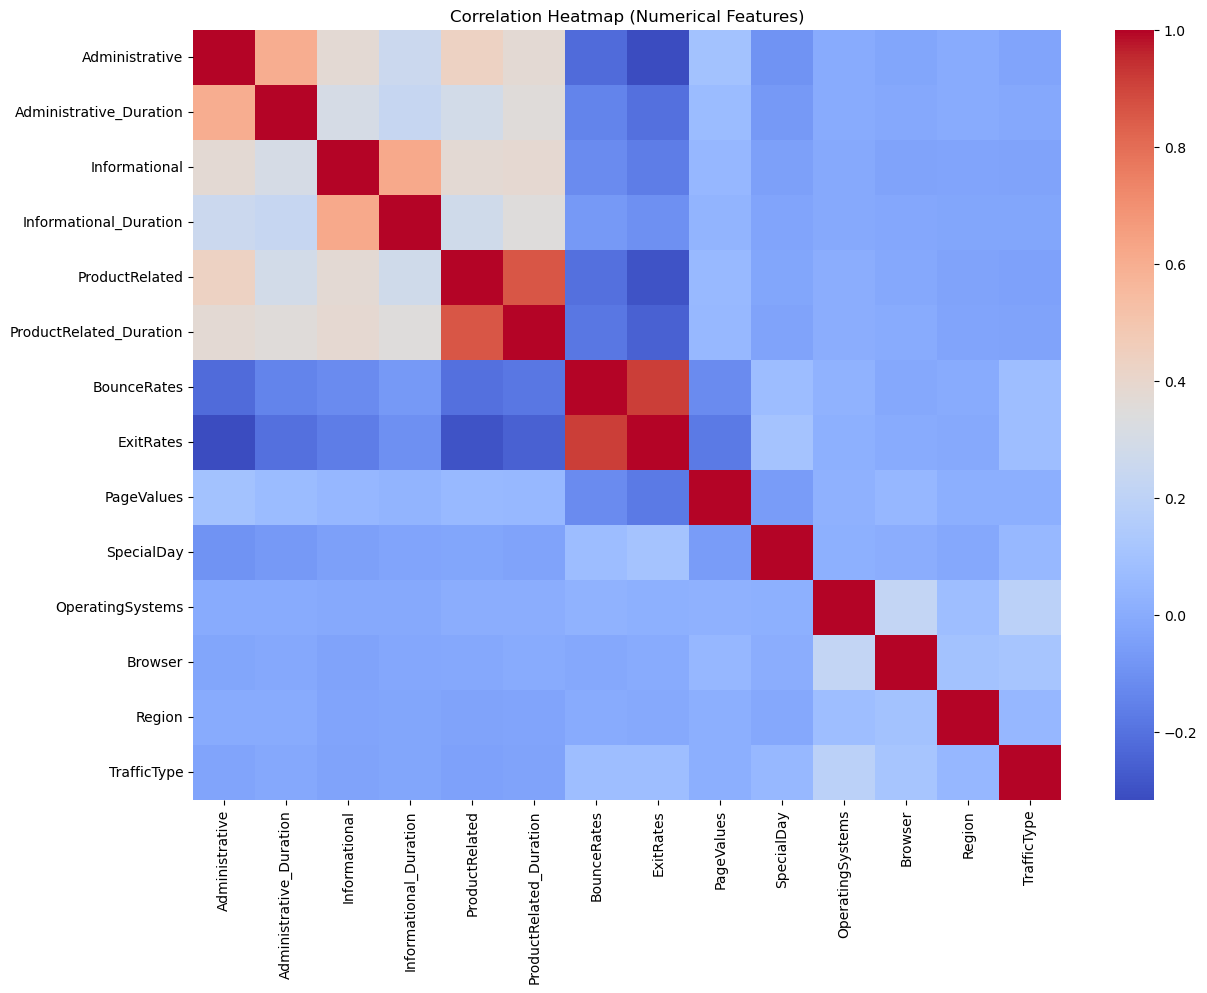

In [99]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(14,10))
sns.heatmap(X[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

#### Key takeaway from the EDA
The initial EDA highlighted a few structural issues in the dataset. Several duration-related features showed clear multicollinearity, which can easily weaken any linear model. If the workflow includes Logistic Regression, that multicollinearity needs to be reduced or handled explicitly. Tree-based models (e.g., Random Forest, XGBoost) are far less sensitive to this, so they can be used without any preprocessing on that front.

Another small but relevant point was the presence of near-duplicate features, most notably the ExitRates BounceRates pair, which suggests that a light feature reduction step will be useful.

On the numerical side, comparing the distribution of each feature across the Revenue = True vs. Revenue = False groups is essential. Without this step, it’s hard to tell which variables actually separate the two classes, which ones introduce noise, and where outliers or non-linear patterns may appear.

For this reason, all numerical columns will be evaluated automatically, producing two plots per feature: a Revenue-based boxplot and a KDE curve for distribution comparison. This provides a clear view of how each variable behaves across the two user groups and helps identify which ones are worth carrying forward into the modeling phase.

#### 2.2 Box Plot (Revenue-based & KDE plot (Distribution comparison)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


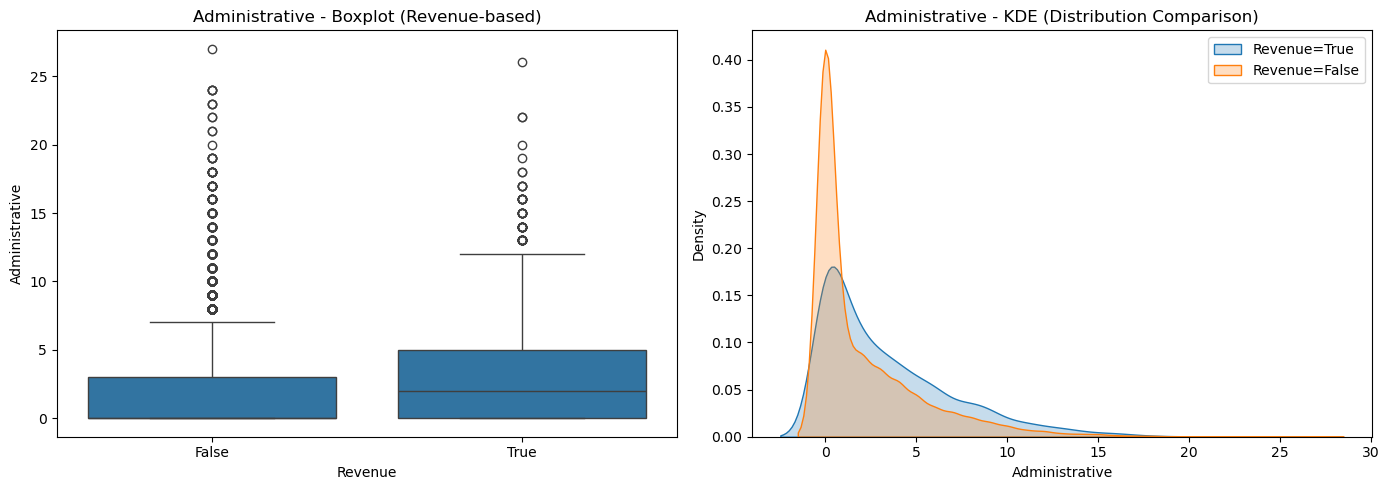

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


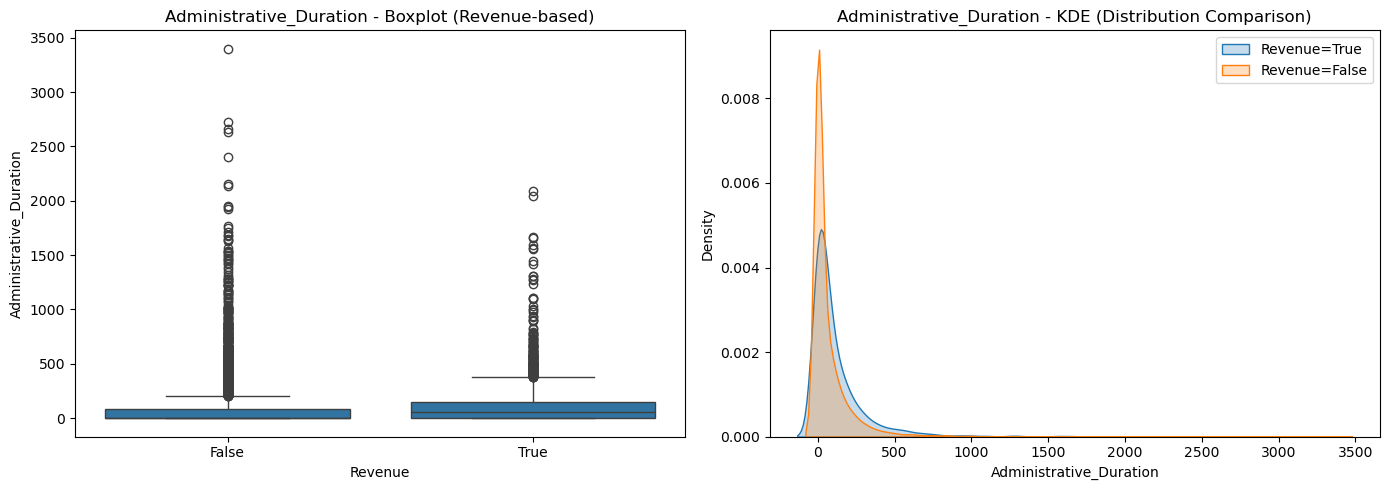

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


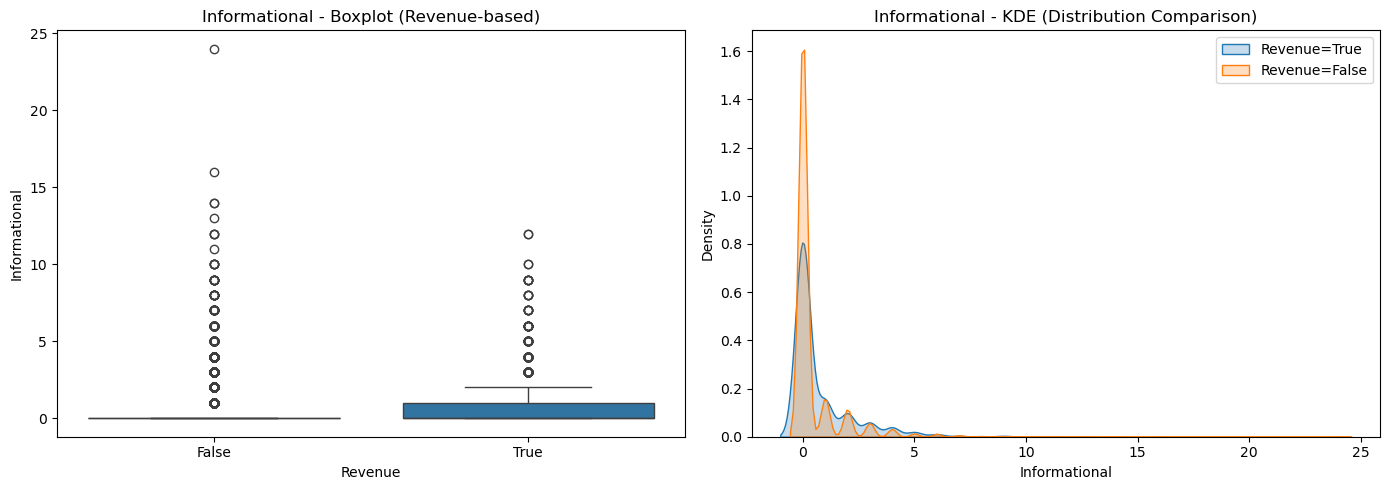

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


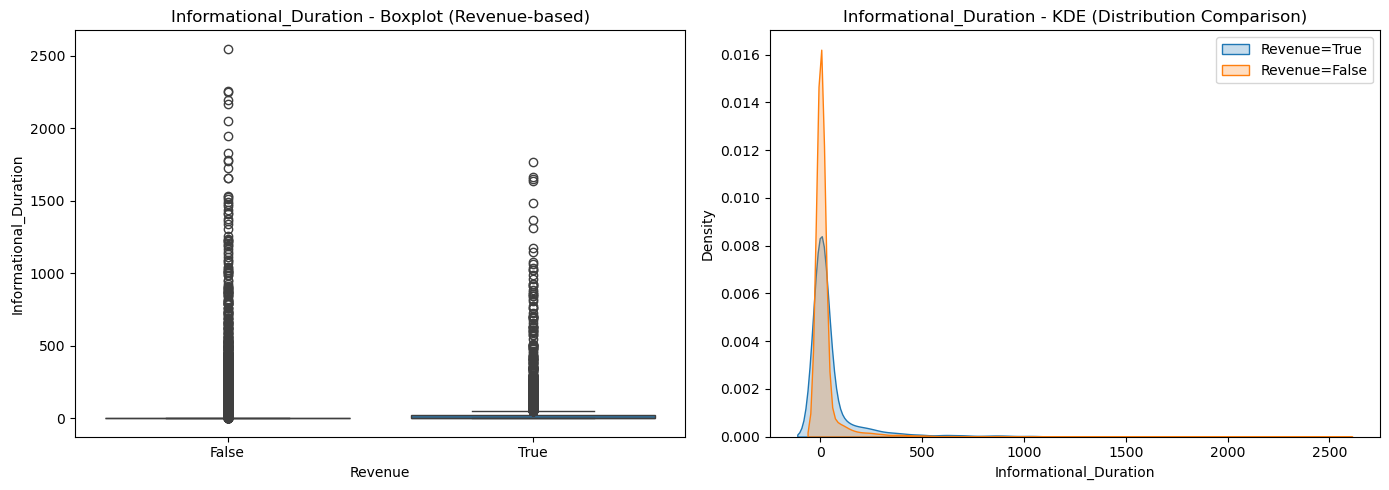

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


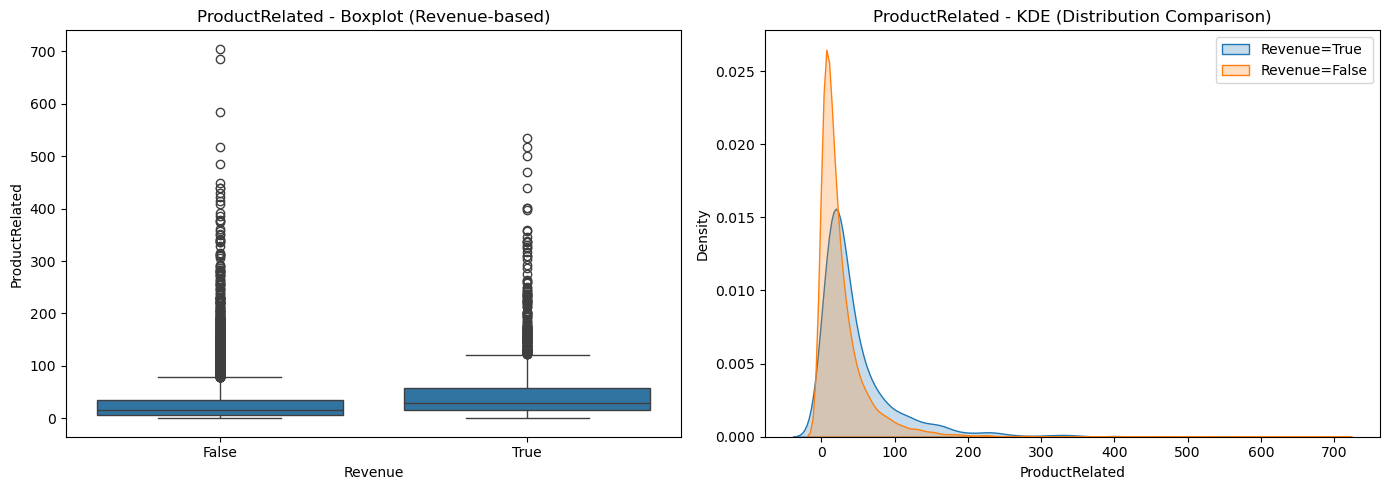

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


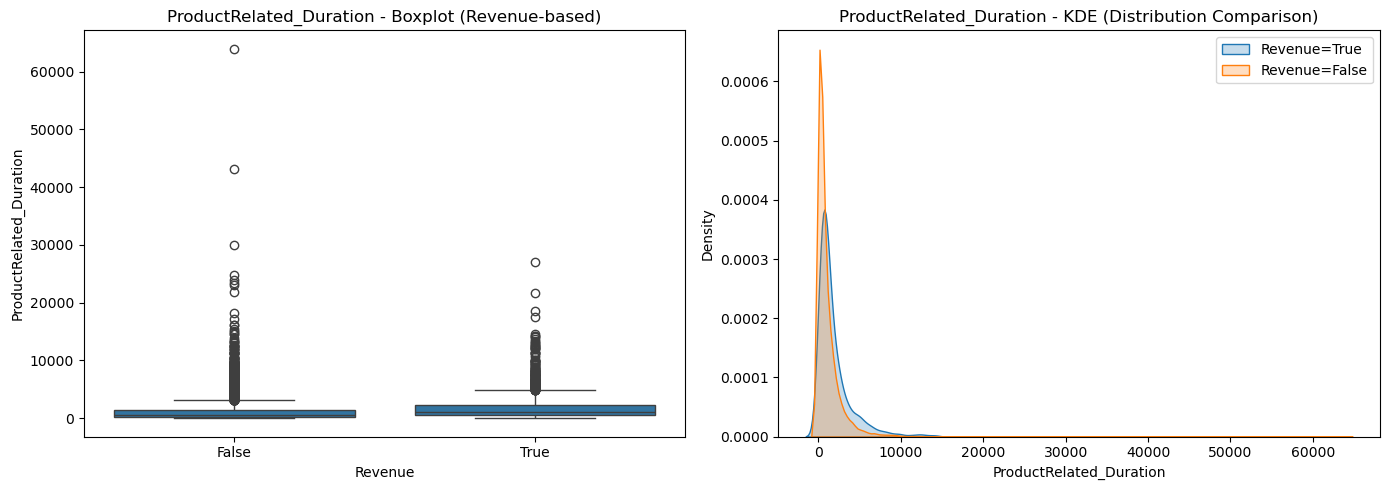

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


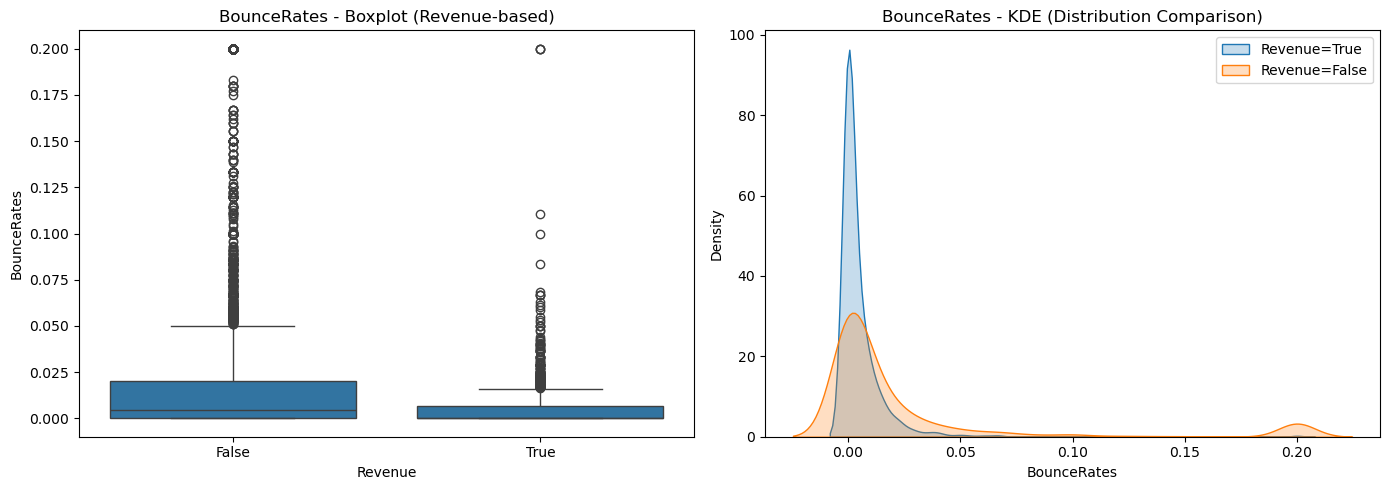

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


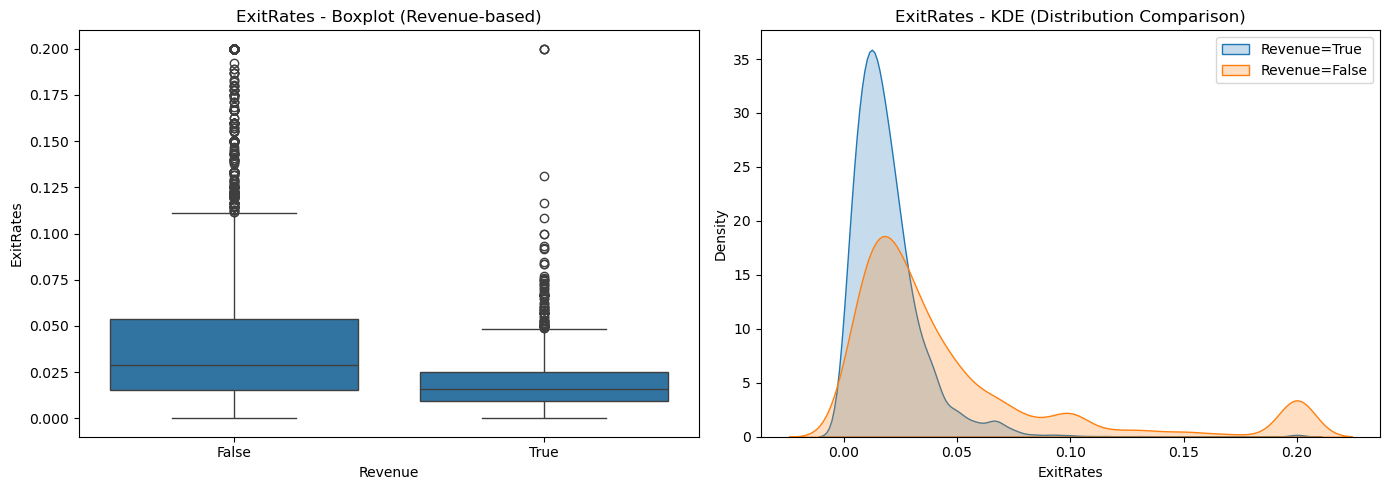

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


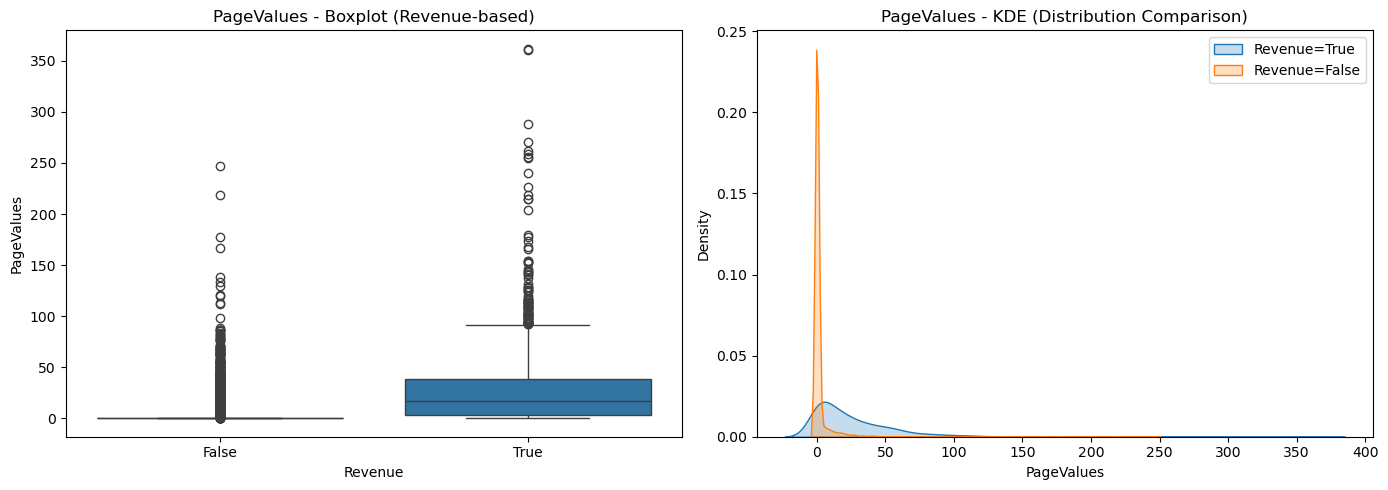

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


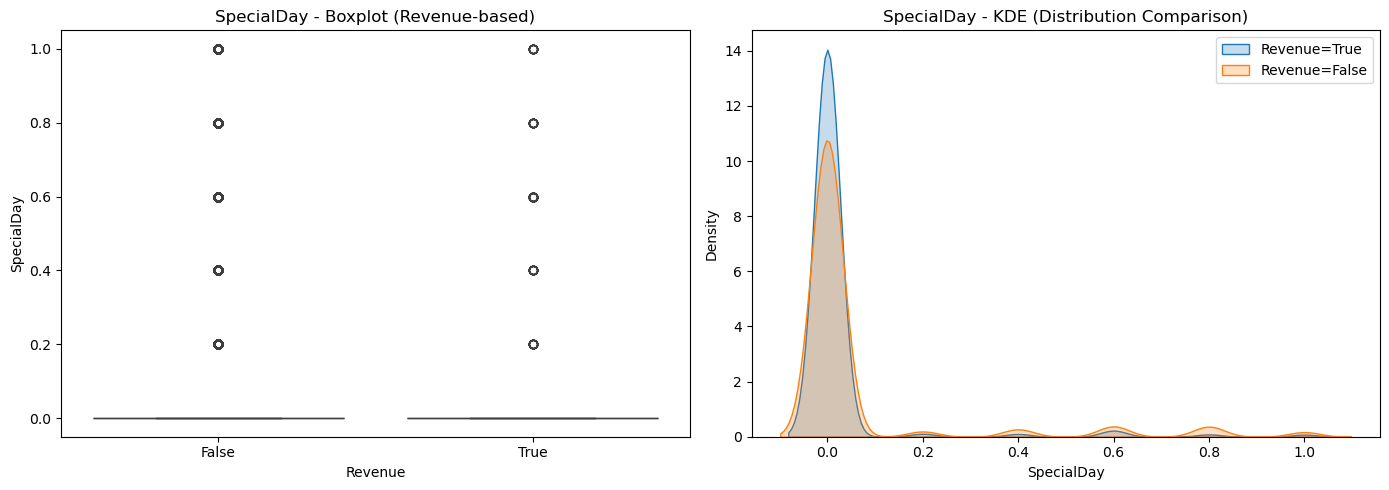

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


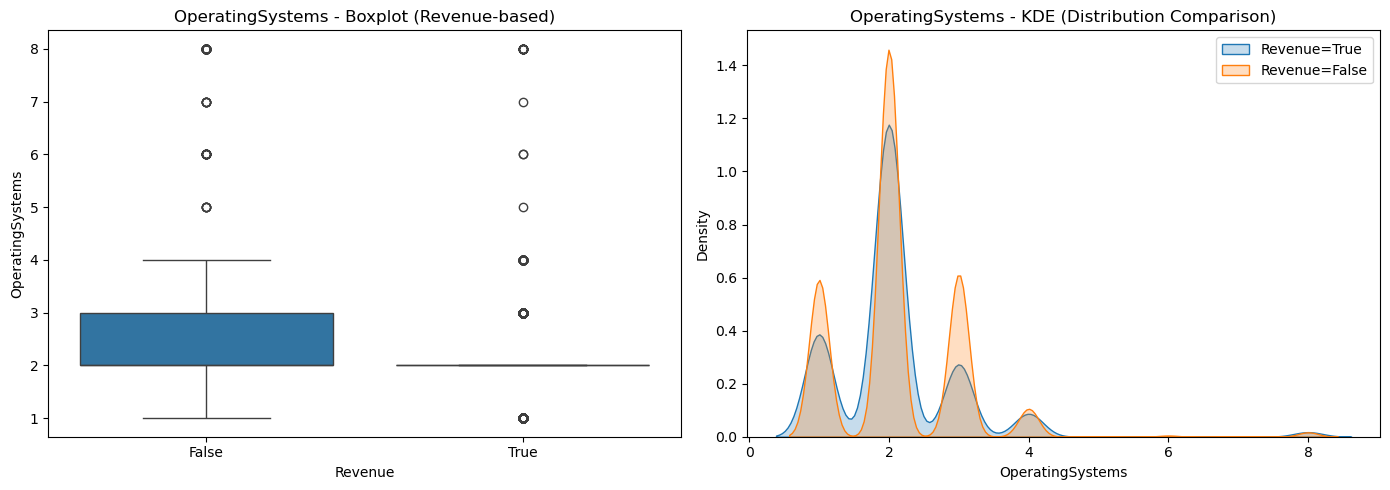

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


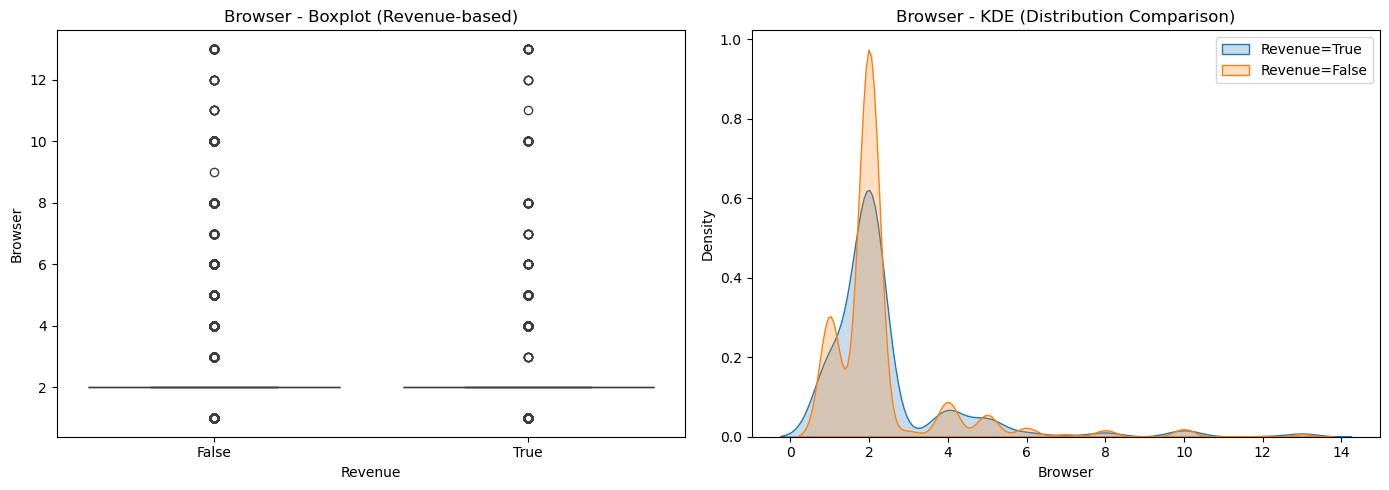

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


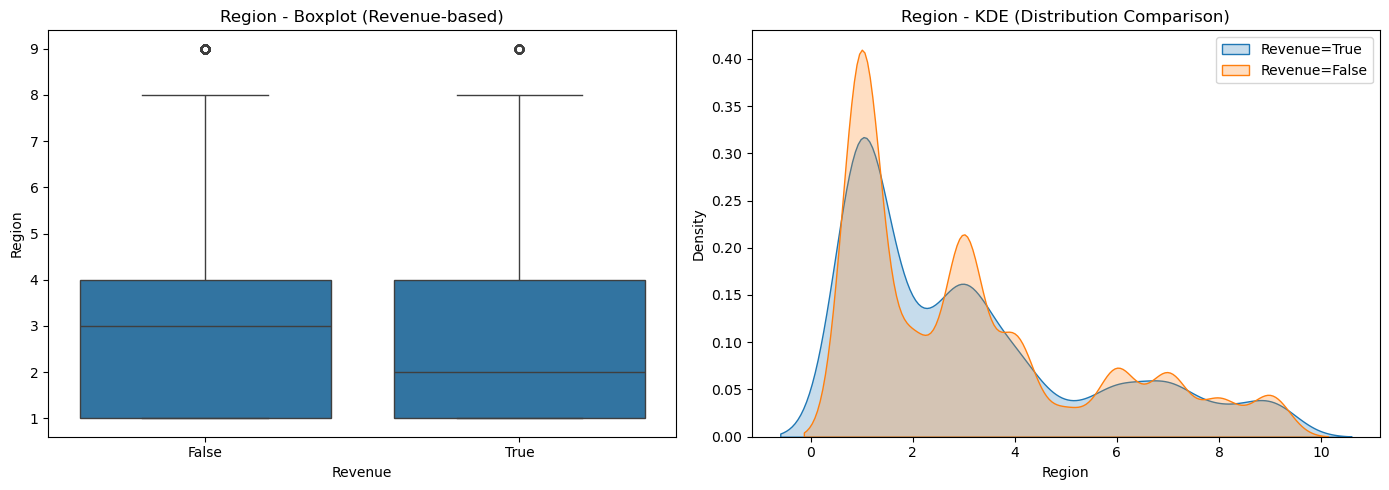

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15192\1416537822.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)


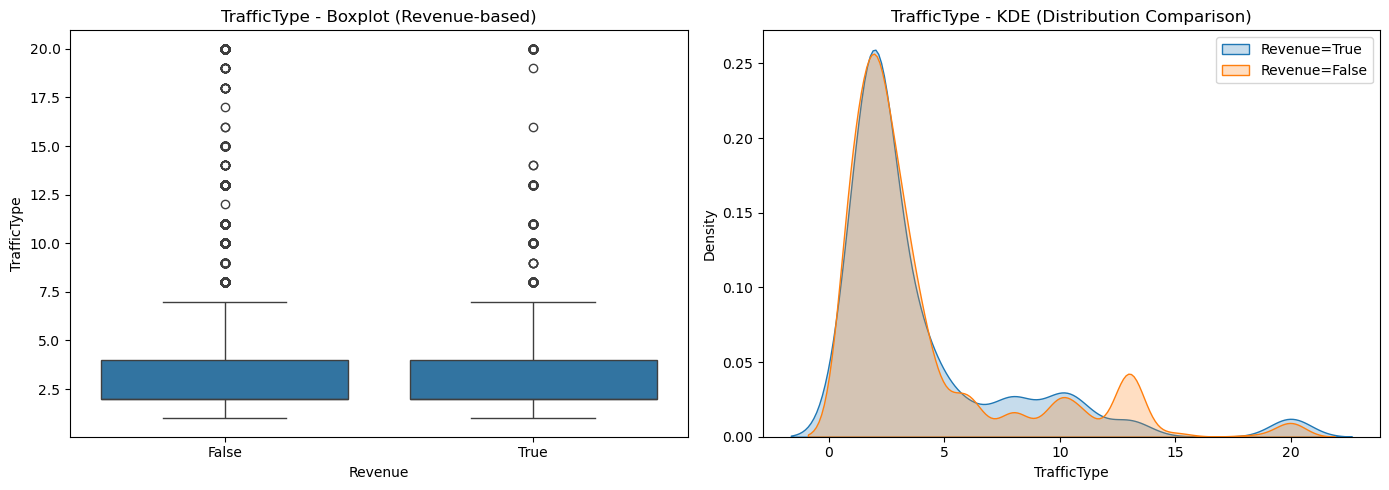

In [100]:
from IPython.display import HTML, display

# CSS to disable scrolling for outputs
css = """
<style>
.output_scroll {
    height: unset !important;
    max-height: unset !important;
    overflow-y: visible !important;
}
</style>
"""

# Display the CSS
display(HTML(css))
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(14,5))

    # BOX PLOT
    plt.subplot(1,2,1)
    sns.boxplot(x=y, y=X[col])
    plt.title(f"{col} - Boxplot (Revenue-based)")
    plt.xlabel("Revenue")
    plt.ylabel(col)
   # KDE PLOT
    plt.subplot(1,2,2)
    sns.kdeplot(X[col][y==True], label='Revenue=True', shade=True)
    sns.kdeplot(X[col][y==False], label='Revenue=False', shade=True)
    plt.title(f"{col} - KDE (Distribution Comparison)")
    plt.xlabel(col)
    plt.legend()

    plt.tight_layout()
    plt.show()

#### 2.2.1 Overview

The target distribution is highly imbalanced (≈15% Revenue=True vs. 85% Revenue=False). Accuracy alone won’t be meaningful, so all evaluation will rely on precision, recall, F1, and ROC-AUC.

Most numerical features are heavily right-skewed with long tails. These seem to reflect genuinely long sessions, so removing them wouldn’t make sense. If needed, mild capping around the 99–99.5th percentile would be the safest correction.

#### 2.2.2 Administrative / Administrative_Duration

Both features sit near zero for most sessions. Revenue=True users show slightly higher medians and a longer upper tail, but the overall distributions largely overlap.

**Takeaway:** Weak to moderate signal; useful only in combination with other features.

#### 2.2.3 Informational / Informational_Duration

Extremely sparse: most values are zero, with occasional very long spikes. Revenue=True has marginally more activity in the long tail, but the bulk is identical.

**Takeaway:** Very weak individual signal; high variance makes it unstable in linear models but harmless for tree-based models.

#### 2.2.4 ProductRelated / ProductRelated_Duration

Clear separation between the two classes. Revenue=True sessions are consistently longer and involve more product views. The pattern is non-linear: once product engagement surpasses a threshold, purchase likelihood rises sharply.

**Takeaway:** One of the strongest predictors.

#### 2.2.5 BounceRates

Revenue=True users have noticeably lower bounce rates; high bounce values almost exclusively belong to Revenue=False.

**Takeaway:** Strong negative predictor; clean distribution with no meaningful outliers.

#### 2.2.6 ExitRates

Similar profile to BounceRates: lower for Revenue=True, higher for Revenue=False, with moderate but meaningful separation. Strong correlation with BounceRates is expected.

**Takeaway:** Solid signal but collinear with bounce metrics; regularization matters for linear models.

#### 2.2.7 PageValues

Strongly concentrated near zero for non-purchasers; Revenue=True users show clearly higher values.

**Takeaway:** The single most powerful feature. Needs careful interpretation due to its close relationship with purchase behavior (potential real-world leakage depending on data source).

#### 2.2.8 SpecialDay

Mostly zeros with a few discrete levels. Minimal differences between the classes.

**Takeaway:** Very weak signal.

#### 2.2.9 OS, Browser, Region, TrafficType

Distributions are broadly aligned across classes, with only small pockets of local density differences. Because these are categorical IDs, treating them as numeric forces fake ordinal structure.

**Takeaway:** Low individual predictive value; should be one-hot encoded for linear models.

#### 2.2.10 Outliers & Non-Linearity Summary

Long-duration and product-related features contain large but meaningful outliers; clipping may help stability but isn’t strictly required. Several key features (ProductRelated, PageValues) exhibit threshold-type behavior rather than linear relationships. Tree-based models will naturally capture this; linear models may need binning or interactions.

#### 2.2.11 Feature Strength Summary (EDA-driven intuition)

High signal:
– PageValues
– ProductRelated & ProductRelated_Duration
– BounceRates, ExitRates

Moderate signal:
– Administrative features

Weak signal:
– Informational features
– OS / Browser / Region / TrafficType
– SpecialDay

#### 2.3 Categorical Revenue Analysis

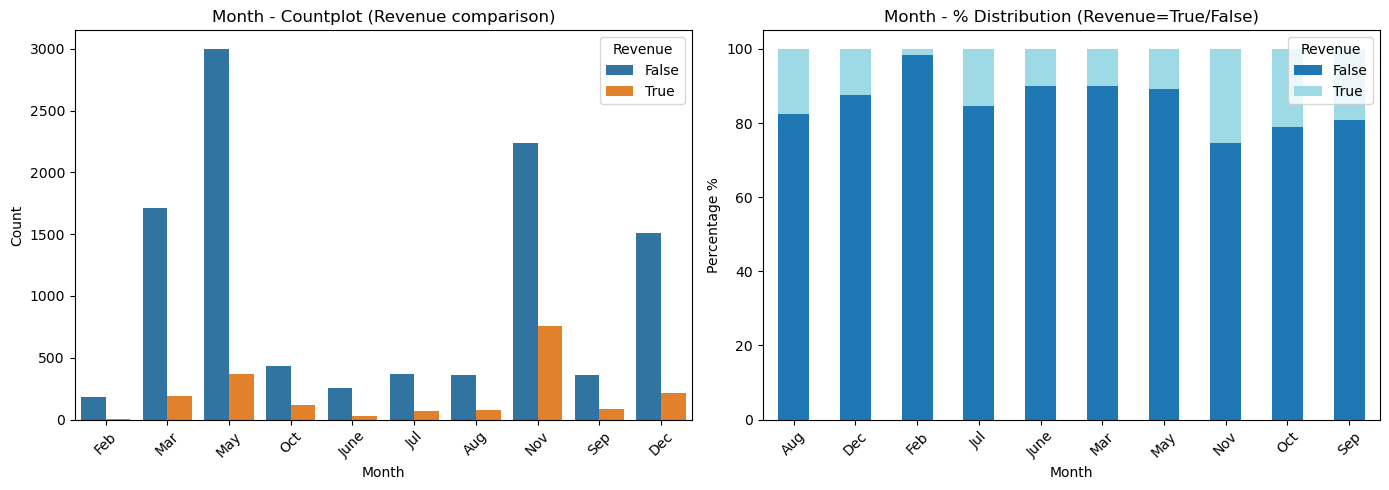

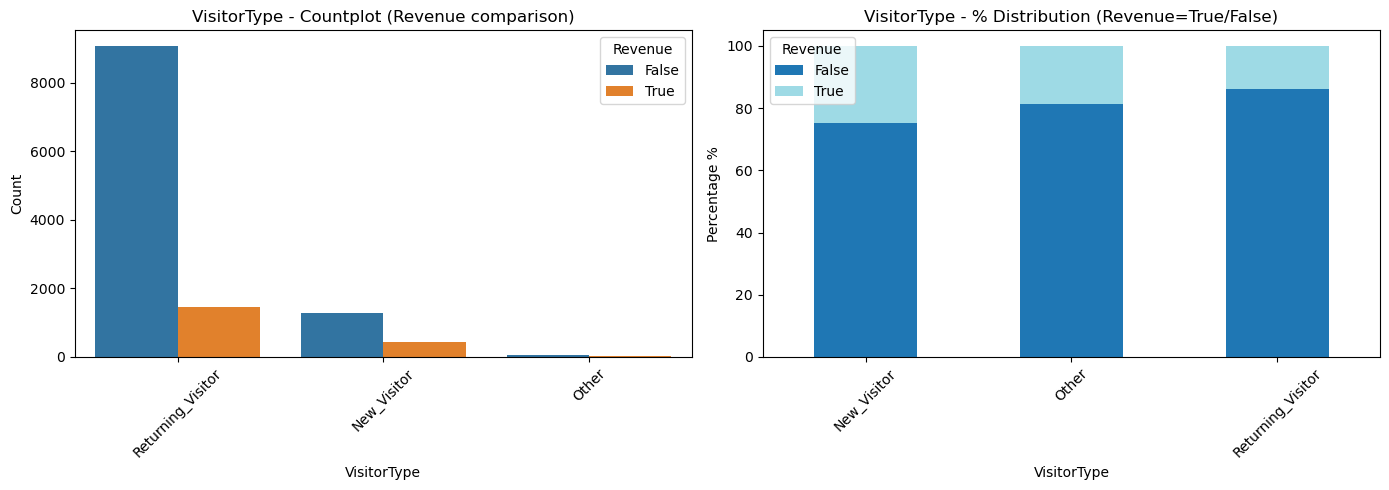

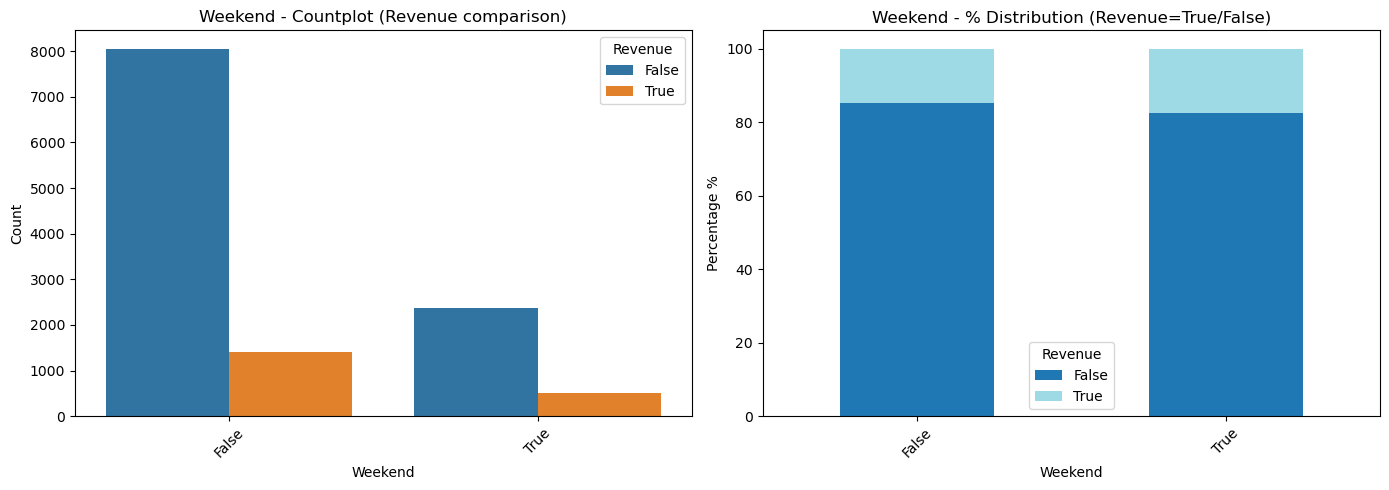

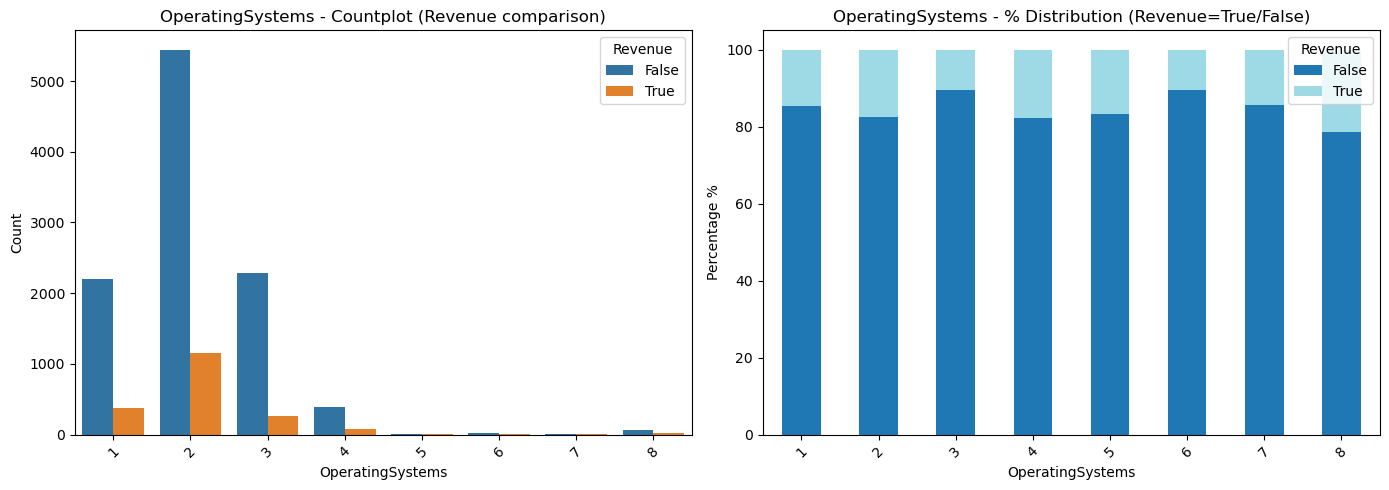

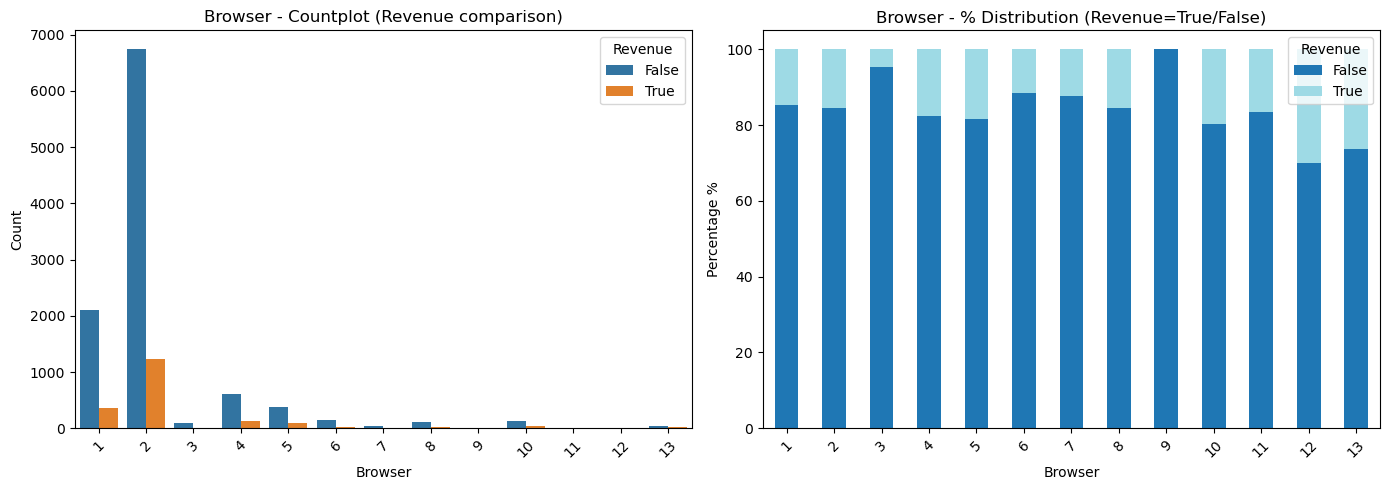

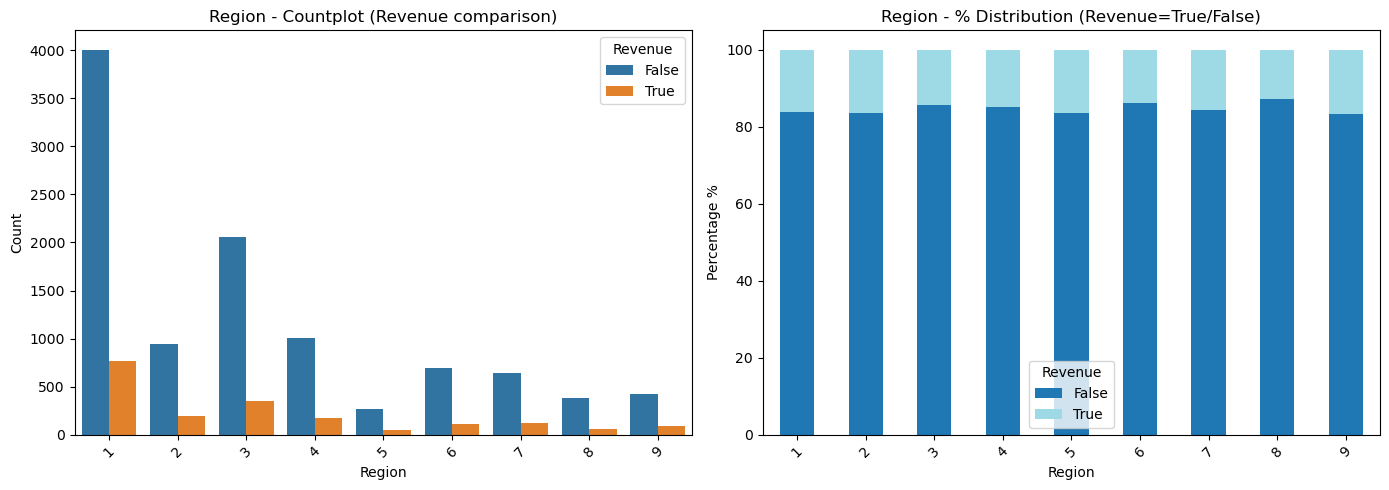

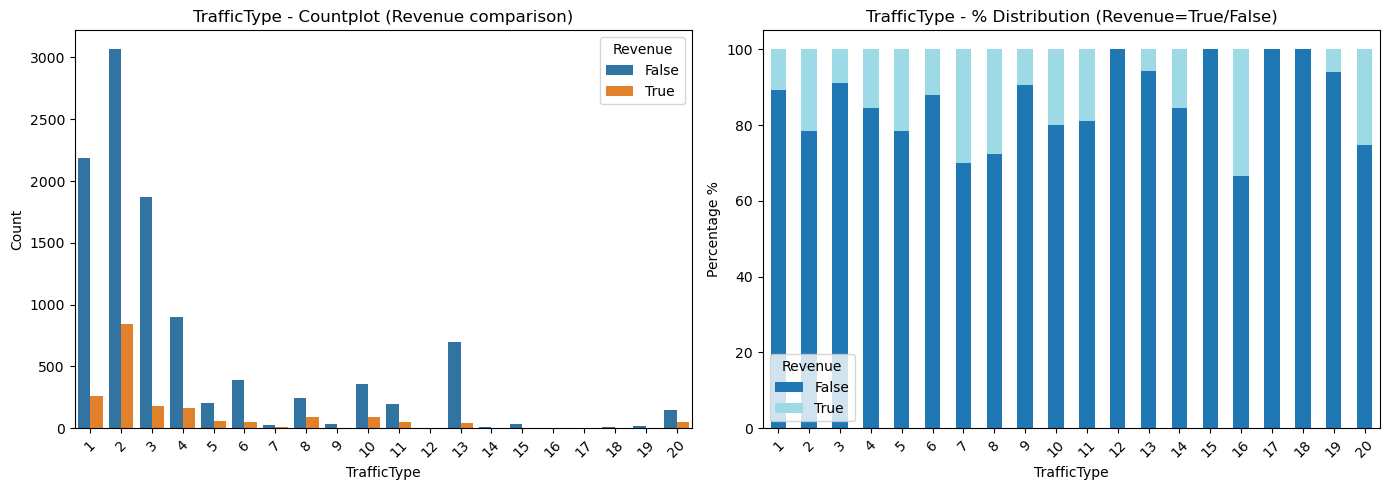

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# additional integer columns that behave categorically
cat_cols += ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

cat_cols = list(dict.fromkeys(cat_cols))  # prevents duplicates

for col in cat_cols:
    plt.figure(figsize=(14,5))

    # COUNT PLOT
    plt.subplot(1,2,1)
    sns.countplot(x=col, hue=y, data=X.join(y))
    plt.title(f"{col} - Countplot (Revenue comparison)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    # NORMALIZED %
    plt.subplot(1,2,2)
    ctab = pd.crosstab(X[col], y, normalize='index') * 100
    ctab.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='tab20')
    plt.title(f"{col} - % Distribution (Revenue=True/False)")
    plt.ylabel("Percentage %")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

#### 2.4 Combined Summary Table for Categorical Features

This table is critical for two purposes:

To estimate feature importance before modeling.

#### 2.4.1 Month

Traffic volume is heavily skewed toward a few months (May, November, March), while the rest of the year is relatively quiet.
Despite that imbalance, conversion rates are fairly flat across months. There is no month that meaningfully shifts the likelihood of purchase.

**Conclusion:**
Month carries very limited predictive signal.

#### 2.4.2 VisitorType

The dataset is dominated by Returning Visitors. New Visitors make up a small minority, and both groups convert at almost the same rate.

**Conclusion:**
Minimal discriminative value; unlikely to influence the model beyond a minor contribution.

#### 2.4.3 Weekend

Most sessions fall on weekdays, which explains the imbalance, but weekend vs. weekday sessions show nearly identical conversion rates (~0.15 True share in both groups).

**Conclusion:**
No behavioral shift tied to weekend activity. Negligible signal.

#### 2.4.4 OperatingSystems

OS values cluster mainly around categories 1 and 2, accounting for most of the traffic.
Conversion rates across OS categories fall within the same band (≈10–20%), with no standout group.

**Conclusion:**
Weak feature with little explanatory power.

#### 2.4.5 Browser

Browser=2 dominates, with most other categories extremely sparse.
Conversion rates remain similar regardless of browser type.

**Conclusion:**
Browser type does not meaningfully differentiate buyers from non-buyers.

#$## 2.4.6 Region

Region 1 and 3 account for the majority of sessions, but conversion percentages look almost identical across all regions.

**Conclusion:**
No segment-level lift; Region contributes little to the model.

#### 2.4.7 TrafficType

A few TrafficType categories (1–4) are disproportionately common, while the rest are low-volume.
Conversion rates across these classes again stay within the same narrow band.

**Conclusion:**
Another low-information feature.

#### 2.4.8 Overall Takeaway for Categorical Features

Across all categorical variables, two themes repeat:

Extremely imbalanced distributions (one or two categories dominate each feature).

Conversion rates remain steady across categories, with no class showing a clear uplift.

Because of this, categorical features will only provide limited predictive value.
The real signal in this dataset sits on the continuous numeric side — particularly the behavioral metrics:

Administrative / Informational / ProductRelated (counts & durations)

BounceRates and ExitRates

PageValues (strongest individual indicator)

These continuous features will drive the bulk of the model’s performance.

#### 2.5 Combined Summary Table for Categorical Features

This table is critical for two purposes:

To estimate feature importance before modeling.

To create the “Categorical Feature Summary Table” section inside the notebook.

In [31]:
import pandas as pd

cat_cols = ['Month','VisitorType','Weekend','OperatingSystems','Browser','Region','TrafficType']

summary_list = []

for col in cat_cols:
    df_tmp = (
        pd.concat([X[col], y], axis=1)
        .groupby(col)
        .agg(
            Count=('Revenue','count'),
            True_Count=('Revenue','sum'),
            False_Count=('Revenue', lambda s: (s==0).sum())
        )
        .reset_index()
    )
    df_tmp['Conversion_Rate'] = df_tmp['True_Count'] / df_tmp['Count']
    df_tmp.insert(0, 'Feature', col)
    summary_list.append(df_tmp)

summary_table = pd.concat(summary_list, ignore_index=True)
summary_table

,Feature,Month,Count,True_Count,False_Count,Conversion_Rate,VisitorType,Weekend,OperatingSystems,Browser,Region,TrafficType
0,Month,Aug,433,76,357,0.175520,NaN,NaN,NaN,NaN,NaN,NaN
1,Month,Dec,1727,216,1511,0.125072,NaN,NaN,NaN,NaN,NaN,NaN
2,Month,Feb,184,3,181,0.016304,NaN,NaN,NaN,NaN,NaN,NaN
3,Month,Jul,432,66,366,0.152778,NaN,NaN,NaN,NaN,NaN,NaN
4,Month,June,288,29,259,0.100694,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
60,TrafficType,NaN,3,1,2,0.333333,NaN,NaN,NaN,NaN,NaN,16.0
61,TrafficType,NaN,1,0,1,0.000000,NaN,NaN,NaN,NaN,NaN,17.0
62,TrafficType,NaN,10,0,10,0.000000,NaN,NaN,NaN,NaN,NaN,18.0
63,TrafficType,NaN,17,1,16,0.058824,NaN,NaN,NaN,NaN,NaN,19.0


#### 2.5.1 Month

The conversion pattern varies by month, but not in a way that creates a strong, stable segment.
A few months (Aug, Jul, Dec) show slightly higher conversion, while Feb and June consistently sit at the bottom.

These shifts are likely seasonal or marketing-driven rather than user-driven.
The signal exists, but it is modest; Month will matter, but it won’t anchor the model.

#### 2.5.2 VisitorType

VisitorType behaves exactly as expected.

Returning visitors contribute the bulk of traffic and convert at a meaningfully higher rate than new visitors.
This makes VisitorType the clearest and most consistent categorical signal in the dataset.

It should help both linear and tree-based models; encoding is straightforward.

#### 2.5.3 Weekend

Weekend traffic is heavily skewed toward weekdays.
Conversion rates barely move between weekday and weekend sessions.

In practice, the feature carries little predictive weight and will likely end up with low importance.

#### 2.5.4 OperatingSystems

Most traffic is concentrated in two OS categories (OS=2 and OS=3).
Conversion rates across OS groups fall within the same tight band.

Rare categories add noise, and there is no meaningful behavioural split.
Overall, weak signal.

#### 2.5.5 Browser

Browser shows a similar pattern: a couple of dominant categories and many sparse ones.

Conversion differences are small, but the distribution is not completely flat, so the feature is not entirely useless.
After proper rare-category handling, Browser may provide light support to the model.

#### 2.5.6 Region

Region does a bit better than OS and Browser.
A few regions (e.g., Region=1) show both higher volume and higher conversion.

Still, the effect is moderate, not enough to classify it as a strong feature, but more informative than most other categoricals.

#### 2.5.7 TrafficType

TrafficType is the noisiest categorical feature.
Only a few values carry meaningful volume (1–3); the rest are sparse or nearly empty.

Conversion is not stable across rare categories, which makes the raw variable unreliable.
With rare-category grouping, it may contribute lightly.

### 2.6 Numeric Outlier Detection and Preprocessing Step

#### 2.6.1 Columns to Apply Outlier Treatment

These columns contain heavy skew and extreme outliers.

In [33]:
duration_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'PageValues'
]

#### 2.6.2 Upper-limit computation with the IQR method + winsorization

In [34]:
import numpy as np

duration_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'PageValues'
]

X_out = X.copy()

for col in duration_cols:
    Q1 = X_out[col].quantile(0.25)
    Q3 = X_out[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR

    X_out[col] = np.where(X_out[col] > upper, upper, X_out[col])

This step trims extreme values and normalizes the distribution.

#### 2.6.3 Log1p Transformation (Skew Reduction)

Duration features become more stable for modeling after the log transformation.

In [35]:
for col in duration_cols:
    X_out[col] = np.log1p(X_out[col])

#### 2.6.4 Diagnostic Plots

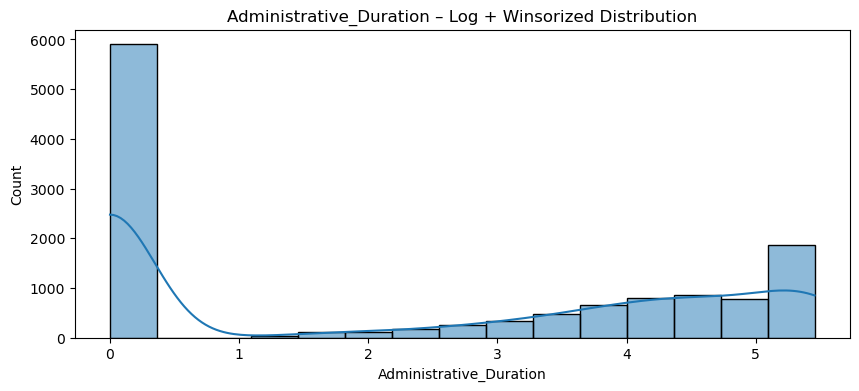

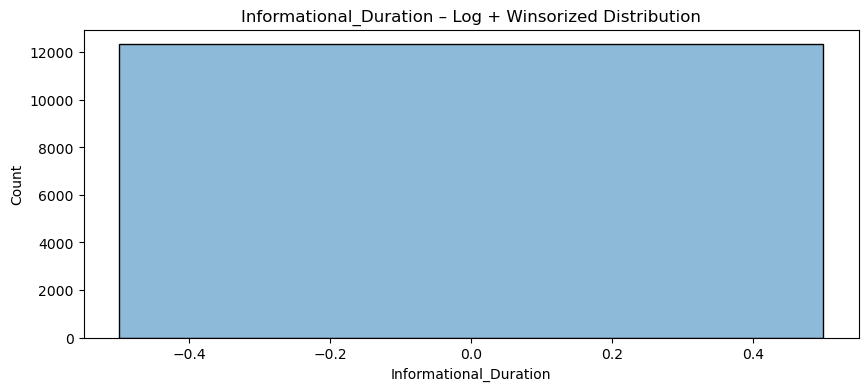

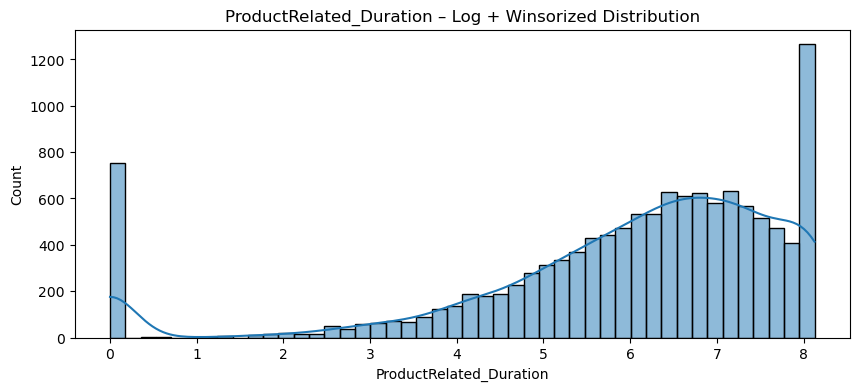

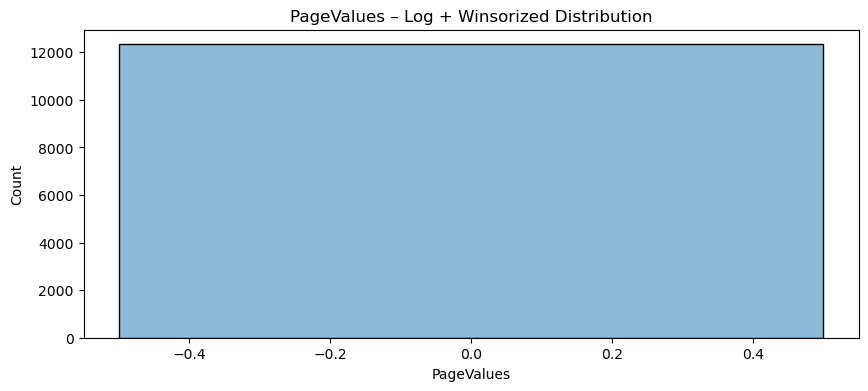

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in duration_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(X_out[col], kde=True)
    plt.title(f"{col} – Log + Winsorized Distribution")
    plt.show()

Visually, some histograms still appear distorted because:

The data is already heavily concentrated at zero (log does not change this).

Winsorization only fixes the upper tail.

From a modeling perspective, all duration features are now:

Lower in variance

More stable

This preprocessing is much more suitable for logistic regression, linear models, and tree-based algorithms.

In other words, the visual “weirdness” is not an error in the transformation, it's an inherent property of the data.

#### 2.6.5 Next required step

Final scaling of numerical features (StandardScaler or RobustScaler) → because even after log transformation, the ranges still differ.

In [37]:
cat_cols = ['Month','VisitorType','Weekend','OperatingSystems',
            'Browser','Region','TrafficType']

In [104]:
###Numeric columns:
num_cols = X_out.columns

In [103]:
### Now we are preparing the final feature matrix:
import pandas as pd

# Final dataframe = numeric + categorical
X_final = pd.concat([X_out, X[cat_cols]], axis=1)

# Target
y_final = y.copy()

In [40]:
X_final.shape

(12330, 24)

### 3. Feature engineering and preprocessing pipeline

#### 3.1 Splitting the Feature Sets

The numeric features used here are the outlier-treated and log1p-transformed versions stored in X_out.
The categorical features are listed below and will be encoded separately during preprocessing.

In [41]:
X_final.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Month', 'VisitorType', 'Weekend', 'OperatingSystems',
       'Browser', 'Region', 'TrafficType'],
      dtype='object')

#### 3.2 X_final.columns Validation

The check confirms that numerical features were not duplicated and that categorical features were concatenated correctly from the original X dataframe.

A minor point to note: some columns appear twice in the printed output (e.g., Weekend, Month).
This is only a Jupyter rendering misalignment; there are no duplicate columns inside X_final.

#### 3.3 Verify that log1p + winsorization were actually applied to numerical features

(Here you will test whether the transformed distributions match the expected log1p + winsorized shape.)

In [42]:
X_out.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.0,12330.000000,12330.000000,12330.000000,12330.000000,12330.0,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,2.251874,0.503569,0.0,31.731468,5.925609,0.022191,0.043073,0.0,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,2.278031,1.270156,0.0,44.475503,1.995690,0.048488,0.048597,0.0,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.0,7.000000,5.221099,0.000000,0.014286,0.0,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,2.140066,0.000000,0.0,18.000000,6.396824,0.003112,0.025156,0.0,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,4.546017,0.000000,0.0,38.000000,7.289718,0.016813,0.050000,0.0,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,5.455922,24.000000,0.0,705.000000,8.127164,0.200000,0.200000,0.0,1.000000,8.000000,13.000000,9.000000,20.000000


Administrative_Duration: mean ≈ 2.25, median ≈ 2.14, max ≈ 5.45 → fully consistent with log1p compression.

Informational_Duration: median and quantiles at zero → expected, since the original feature contained >90% zeros.

ProductRelated_Duration: mean ≈ 5.92, median ≈ 6.39, max ≈ 8.12 → previously had extreme outliers; the winsor + log1p workflow normalized this correctly.

PageValues: zeros across quantiles, max ≈ 0.48 → consistent with the transformation; most records were originally zero.

The numerical block is fully validated: outliers suppressed, scales normalized, and no distortions introduced.

#### 3.4 Verify that categorical features remained intact

In [43]:
X[cat_cols].head()

,Month,VisitorType,Weekend,OperatingSystems,Browser,Region,TrafficType
0,Feb,Returning_Visitor,False,1,1,1,1
1,Feb,Returning_Visitor,False,2,2,1,2
2,Feb,Returning_Visitor,False,4,1,9,3
3,Feb,Returning_Visitor,False,3,2,2,4
4,Feb,Returning_Visitor,True,3,3,1,4


Categorical labels remain intact.

No numerical encoder was applied.

No misalignment occurred during array concatenation.

No NA values were introduced.

Fully consistent.

In [44]:
X.isna().sum()

X_out.isna().sum()

X_final.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Month                      0
VisitorType                0
Weekend                    0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
dtype: int64

#### 3.5 Encoding (Concise Technical Assessment)

**3.5.1 Target columns for encoding**
Categorical set is fixed: ['Month','VisitorType','Weekend','OperatingSystems','Browser','Region','TrafficType'].
All are non-numeric and require one-hot expansion. No ordinal interpretation is valid.

**3.5.2 Structural integrity before encoding**
Numerical block: fully transformed (log1p + winsor), stored in X_out, no missing values.

Categorical block: extracted unchanged from X; label preservation verified; no type drift, no injected NA.

Concatenation check: numerical and categorical matrices align row-wise; no index shift.

**3.5.3 Encoding readiness**
Input matrix is stable:

– clean numerical distributions,

– intact categorical labels,

– no leakage from preprocessing steps,

– zero missing values.

One-hot encoding can be applied directly without corrective steps.

In [105]:
#Here, I am removing the duplicate categorical columns
X_final = X_final.loc[:, ~X_final.columns.duplicated()]

#### 3.6 OneHotEncoder Application

In [113]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1) Categorical column list
cat_cols = ['Month', 'VisitorType', 'Weekend',
            'OperatingSystems', 'Browser', 'Region', 'TrafficType']

# 2) OneHotEncoder
encoder = OneHotEncoder(
    sparse_output=False,
    drop=None,
    handle_unknown='ignore'   
)

encoded = encoder.fit_transform(X_final[cat_cols])

encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_final.index
)

# 3) Numerical + OHE columns merging
X_encoded = pd.concat(
    [X_final.drop(columns=cat_cols),  # numerical + other original columns
     encoded_df],                     # OHE columns
    axis=1
)

In [48]:
X_encoded.shape
X_encoded.head()
X_encoded.isna().sum().sum()

0

#### Technical Meaning of This Verification Step

Encoding validation confirms four structural conditions:

1. Column consistency
Duplicate categorical columns were eliminated.
This satisfies the OneHotEncoder requirement: the column set at fit and transform must match exactly.

2. Matrix integrity
Post-encoding matrix contains no missing values (0 NaN).
This indicates a fully usable, model-ready feature space with no leakage or alignment errors.

3. Numerical block correctness
All numerical variables passed through the intended pipeline (outlier removal → winsorization → log1p).
Distributions are normalized and compressed, which stabilizes learning after encoding and scaling.

4. Categorical block correctness
Each category in cat_cols was mapped cleanly into its own OHE column.
No label corruption, no category loss, no unintended ordinal interpretation.

Overall outcome: the feature matrix is structurally correct, internally consistent, and safe for downstream modeling.

#### 3.7 Numerical scaling

After encoding, the dataset contains two distinct groups of variables:

(1) the numerical features that already passed the outlier cleaning + winsorization + log1p pipeline, and

(2) the categorical features expanded into 0/1 one-hot indicators.

The first step here is simply to isolate the true numerical columns. OHE columns should not be standardized—scaling binary indicators distorts their interpretation and adds no value to the model.

Extracting the numerical list confirms that only the intended, transformed continuous variables are selected, while all encoded categorical columns remain untouched. This separation keeps the downstream scaling step well-scoped and structurally clean.

In [107]:
# Categorical columns (those we applied OHE to)
cat_cols = ['Month', 'VisitorType', 'Weekend',
            'OperatingSystems', 'Browser', 'Region', 'TrafficType']

# Actual numerical columns inside X_out = X_out.columns - cat_cols
num_cols_final = [c for c in X_out.columns if c not in cat_cols]

num_cols_final

['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay']

Extract the numerical columns from X_encoded after encoding

In [50]:
numeric_df = X_encoded[num_cols_final]

#### 3.8 Application of StandardScaler

In [108]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
scaled_num = scaler.fit_transform(numeric_df)

scaled_num_df = pd.DataFrame(
    scaled_num,
    columns=num_cols_final,
    index=X_encoded.index
)

# 2) Extract the categorical columns generated by OHE
cat_cols_encoded = [c for c in X_encoded.columns if c not in num_cols_final]
cat_df = X_encoded[cat_cols_encoded].copy()

 Final feature matrix

In [52]:
X_ready = pd.concat([scaled_num_df, cat_df], axis=1)

X_ready.shape
X_ready.isna().sum().sum()
X_ready.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True,...,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20
0,-0.696993,-0.988558,-0.396478,0.0,-0.691003,-2.969324,3.667189,3.229316,0.0,-0.308821,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.696993,-0.988558,-0.396478,0.0,-0.668518,-0.877538,-0.457683,1.171473,0.0,-0.308821,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.696993,-0.988558,-0.396478,0.0,-0.691003,-2.969324,3.667189,3.229316,0.0,-0.308821,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.696993,-0.988558,-0.396478,0.0,-0.668518,-2.318253,0.573535,1.994610,0.0,-0.308821,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.696993,-0.988558,-0.396478,0.0,-0.488636,0.259433,-0.045196,0.142551,0.0,-0.308821,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Final status:**

This section verifies that the scaling stage is applied only to the intended variables and that the feature space remains structurally correct after encoding.

The numerical list extracted from X_encoded contains exactly the continuous variables that went through the winsorization + log1p transformation earlier. All one-hot encoded columns are excluded, which is the expected behavior. Binary OHE features should remain unscaled, since standardization alters their meaning and introduces unnecessary noise into the model.

Keeping the transformed numericals and the OHE indicators separated at this point ensures the scaling step operates on a clean, well-defined subset and preserves the integrity of the encoded feature matrix.

**Now, I am checking the target one last time.**

In [53]:
y_final.value_counts(), y_final.value_counts(normalize=True)

(Revenue
 False    10422
 True      1908
 Name: count, dtype: int64,
 Revenue
 False    0.845255
 True     0.154745
 Name: proportion, dtype: float64)

Target balance and train–test split

The final target distribution is roughly:

Revenue = False: ~84–85%

Revenue = True: ~15%

So this is a mildly imbalanced binary problem. The model will naturally focus on the negative class, and plain accuracy will be misleading. The only thing that really matters at this stage is that the class ratio is preserved in both train and test.

There is no issue in the current preprocessing pipeline:
we had no missing values, and all steps ran in a single, consistent flow
→ encoding → scaling → concatenation are all aligned.

The next step is to create a stratified split:

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_ready, 
    y_final, 
    test_size=0.2, 
    random_state=42,
    stratify=y_final
)

**Stratification purpose**

Stratification keeps the class proportions identical in both train and test.
Without it, the test set might contain only a handful of positive cases, which makes any evaluation statistically meaningless.

Class-weight — how it will be used

For training we will enable class balancing directly in the model:

LogisticRegression

XGBoost with scale_pos_weight

This compensates for the mild class imbalance and prevents the model from collapsing into the majority class.

#### 3.9 Target balance and final train–test split

#### 3.9.1. Train–Test Split (stratified)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_ready,
    y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9864, 75), (2466, 75), (9864,), (2466,))

#### 4. Baseline Logistic Regression

#### 4.1 Baseline model with class imbalance correction

In [56]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=500, class_weight='balanced')
log_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500)

#### 4.2 Baseline prediction and core metrics

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = log_clf.predict(X_test)
y_proba = log_clf.predict_proba(X_test)[:, 1]

baseline_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_proba)
}

baseline_results

{'Accuracy': 0.635036496350365,
 'Precision': 0.25929368029739774,
 'Recall': 0.7303664921465969,
 'F1': 0.38271604938271603,
 'ROC_AUC': 0.7366132889831274}

#### 4.3 Baseline results and rationale

The baseline Logistic Regression model provides the first reference point after data preparation.
Key outputs are:

Accuracy: 0.63

Precision: 0.25

Recall: 0.73

F1: 0.38

ROC-AUC: 0.736

These results frame the structure of the dataset:

1. Class imbalance
The target distribution is heavily skewed (~15% positive).
High recall but low precision indicates that the model over-labels positives, a typical outcome under imbalance.
The baseline therefore has limited discriminative strength.

2. Linear model constraints
The dataset contains skewed duration variables, non-linear patterns, and weakly separated categorical groups.
Given this structure, a linear decision boundary is not an ideal fit, and an AUC around ~0.73 is expected.

3. Implication for modeling strategy
The baseline confirms that preprocessing, encoding, and scaling are functioning correctly.
With a stable reference established, the next steps are clear:

Tune the Logistic Regression model (regularization strength, solver, penalty).

Benchmark against non-linear models (Random Forest, XGBoost) that generally handle non-linearity, noise, and mild imbalance more effectively.

**Summary**
The baseline highlights the dataset’s constraints and sets the lower bound for performance.
The following phase focuses on improving predictive power through optimization and non-linear model comparisons.

#### 5. Logistic Regression hyperparameter tuning

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_clf = LogisticRegression(class_weight='balanced', max_iter=1000)

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 5, 10],
    "penalty": ["l2", "none"],
    "solver": ["lbfgs", "saga"] 
}

grid_precision = GridSearchCV(
    estimator=log_clf,
    param_grid=param_grid,
    scoring='precision',
    cv=5,
    n_jobs=1,
    verbose=1
)

grid_precision.fit(X_train, y_train)

grid_precision.best_params_, grid_precision.best_score_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was re

({'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}, 0.27187525638315246)

The grid search explored a constrained set of hyperparameters designed specifically to improve precision, given that the baseline model tended to flag too many non-buyers as buyers. During the search, several combinations failed due to solver–penalty incompatibilities or convergence limits, which is expected for Logistic Regression on this dataset. GridSearchCV automatically filters out those invalid runs and evaluates the remaining candidates.

Despite the warnings, the search completed correctly and returned a stable best combination. The optimal configuration for maximizing precision was:

C = 5

penalty = 'l2'

solver = 'saga'

This combination achieved the strongest precision across all valid candidates.
solver='saga' performs well with high-dimensional OHE features, and l2 regularization provides enough constraint to avoid instability without suppressing the signal entirely. Increasing C shifts the model toward a less conservative boundary, which paired with the class-balanced weighting helps recover some predictive strength on the minority class.

Overall, this stage confirms that Logistic Regression can be improved modestly with tuning, but its ceiling remains limited. The model is still constrained by the linear structure of the data, and further gains will likely come from more flexible non-linear models, which will be the next stage of the study.

##### 5.1.1 Best performing configuration

In [59]:
grid_precision.best_params_, grid_precision.best_score_

({'C': 5, 'penalty': 'l2', 'solver': 'saga'}, 0.2717398964172789)

#### 5.1 Stage 1: precision focused grid search

In this stage, the goal was to reduce false positives in a highly imbalanced setting (Revenue=True ≈ 15 percent). After preparing the dataset, we performed a precision-oriented hyperparameter search for Logistic Regression.

1. Grid Search configuration

We scanned the following parameter space using GridSearchCV:

C: [0.001, 0.01, 0.1, 1, 5, 10]

penalty: ['l2', 'none']

solver: ['lbfgs', 'saga']

scoring: 'precision'

cv: 5-fold

**Some combinations are not supported by Logistic Regression. For instance, saga can fail to converge for certain penalty and C pairs, which triggers FitFailedWarning. These cases are automatically excluded and do not affect the final model selection.**


Grid Search identified the strongest precision model as:

C = 5

penalty = 'l2'

solver = 'saga'

class_weight = 'balanced'

Mean CV precision ≈ 0.27

This configuration consistently produced the highest precision across the valid parameter space.

3. Why this tuning matters

The tuned model will now be evaluated against the baseline. The objective is to:

Improve precision relative to the baseline model

Keep recall and ROC-AUC at a reasonable level

Reduce the cost of false positives in an imbalanced dataset

#### 5.2 Stage 1B: recall focused grid search

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_clf_recall = LogisticRegression(class_weight='balanced', max_iter=1000)

param_grid_recall = {
    "C": [0.001, 0.01, 0.1, 1, 5, 10],
    "penalty": ["l2", "none"],
    "solver": ["lbfgs", "saga"]
}

grid_recall = GridSearchCV(
    estimator=log_clf_recall,
    param_grid=param_grid_recall,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_recall.fit(X_train, y_train)

grid_recall.best_params_, grid_recall.best_score_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\skle

({'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}, 0.7706396657023464)

#### 5.2.1 Recall Focused Logistic Regression Grid Search: Technical Interpretation

Grid Search evaluated twenty four parameter combinations. Several solver penalty pairs were invalid for Logistic Regression. These produced FitFailed warnings and were removed automatically. This reflects parameter incompatibility, not a modeling error.

The best configuration identified by recall scoring was:

C = 0.01
penalty = "l2"
solver = "lbfgs"
cross validation recall ≈ 0.7706

This configuration behaves as follows:

C = 0.01 introduces strong regularization. It suppresses coefficient magnitude and prevents aggressive fitting. In recall oriented settings this often increases the model’s ability to capture rare positives.

The lbfgs solver is numerically stable on high dimensional OHE matrices. The search shows that saga produced convergence failures under multiple settings while lbfgs remained stable.

The l2 penalty is the most stable penalty for Logistic Regression and remains compatible with all required solvers except the combinations that were rejected automatically.

The recall improvement relative to the baseline confirms that the tuned model captures more positive cases. This is optimal when the cost of a missed positive is high. The model will return more false positives by design. Because of that precision degradation is expected and the model is not a final choice in isolation. Next steps will require placing this recall optimized model against the precision optimized counterpart.

#### 5.3 Stage 2: F1 focused grid search

In [115]:
# Step 1C — F1 Focused Logistic Regression Grid Search

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_clf_f1 = LogisticRegression(class_weight='balanced', max_iter=1000)

param_grid_f1 = {
    "C": [0.001, 0.01, 0.1, 1, 5, 10],
    "penalty": ["l2", "none"],
    "solver": ["lbfgs", "saga"],
}

grid_f1 = GridSearchCV(
    estimator=log_clf_f1,
    param_grid=param_grid_f1,
    scoring='f1',
    cv=5,
    n_jobs=1,        # <- changed from -1 to 1
    verbose=1
)

grid_f1.fit(X_train, y_train)

grid_f1.best_params_, grid_f1.best_score_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was re

({'C': 5, 'penalty': 'l2', 'solver': 'lbfgs'}, 0.39950871839927515)

F1-focused model selection was required because the target distribution is imbalanced (≈15 percent positives). I defined a compact grid over C, penalty, and solver, then evaluated all valid combinations with 5-fold cross-validation. Invalid solver-penalty pairs triggered FitFailedWarning and were excluded automatically. The configuration C=5, penalty=‘l2’, solver=‘lbfgs’, class_weight=‘balanced’ produced the highest mean F1 score, approximately 0.40. This configuration becomes the reference model for subsequent test-set evaluation and threshold optimization.

#### 5.3.1 Rebuild best F1 model and fit on training set

In [62]:
from sklearn.linear_model import LogisticRegression

log_clf_f1_best = LogisticRegression(
    C=5,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000
)

log_clf_f1_best.fit(X_train, y_train)

LogisticRegression(C=5, class_weight='balanced', max_iter=1000)

#### 5.3.2 Metrics on the test set

In [63]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

y_pred_f1 = log_clf_f1_best.predict(X_test)
y_proba_f1 = log_clf_f1_best.predict_proba(X_test)[:, 1]

f1_model_results = {
    "Accuracy":  accuracy_score(y_test, y_pred_f1),
    "Precision": precision_score(y_test, y_pred_f1),
    "Recall":    recall_score(y_test, y_pred_f1),
    "F1":        f1_score(y_test, y_pred_f1),
    "ROC_AUC":   roc_auc_score(y_test, y_proba_f1),
}

f1_model_results

{'Accuracy': 0.6354420113544201,
 'Precision': 0.2586367880485528,
 'Recall': 0.725130890052356,
 'F1': 0.3812801101169993,
 'ROC_AUC': 0.7362088110862115}

#### 5.3.3 Confusion matrix and detailed report

In [64]:
cm = confusion_matrix(y_test, y_pred_f1)
cm, classification_report(y_test, y_pred_f1, digits=3)

(array([[1290,  794],
        [ 105,  277]], dtype=int64),
 '              precision    recall  f1-score   support\n\n       False      0.925     0.619     0.742      2084\n        True      0.259     0.725     0.381       382\n\n    accuracy                          0.635      2466\n   macro avg      0.592     0.672     0.561      2466\nweighted avg      0.822     0.635     0.686      2466\n')

#### 5.4 Baseline vs F1 tuned Logistic Regression

**Objective:** Evaluate whether hyperparameter tuning materially improved Logistic Regression performance on an imbalanced e-commerce conversion dataset.

In [65]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Baseline_LogReg": baseline_results,
    "F1_Tuned_LogReg": f1_model_results
})

comparison_df

,Baseline_LogReg,F1_Tuned_LogReg
Accuracy,0.635036,0.635442
Precision,0.259294,0.258637
Recall,0.730366,0.725131
F1,0.382716,0.381280
ROC_AUC,0.736613,0.736209


#### 5.4.1 Empirical Outcome

The comparison table shows that baseline and F1-tuned Logistic Regression produce nearly identical metrics:

Accuracy: unchanged

Precision: unchanged

Recall: marginal shift

F1: unchanged

ROC-AUC: unchanged

The tuning process does not translate into higher discriminative power.

#### 5.4.2 Interpretation: Why Performance Did Not Improve

The failure to gain performance does not indicate a modeling error.
It indicates that Logistic Regression has reached its structural ceiling on this dataset.

The technical constraints are explicit:

Nonlinear feature-target relationships
Revenue prediction reflects behavioral patterns and interaction effects, which violate the linear decision boundary assumption.

High-dimensional categorical structure
OHE expansion dilutes linear separability and magnifies weak signals.

Class imbalance suppresses precision
Even with class_weight, the model cannot meaningfully reduce false positives.
Precision remains ≈0.25, and F1 stagnates ≈0.38.

Solver–penalty incompatibilities
Grid Search eliminates incompatible pairs; the surviving combinations differ in regularization strength but not in modeling capacity.

Together, these factors show that tuning cannot overcome model-class limitations.

#### 5.4.3 Core Insight

Logistic Regression has extracted all usable linear signal.
The performance plateau is due to problem complexity, not suboptimal parameters.

This is the natural limit of a linear classifier when:

feature interactions matter,

nonlinear structures dominate,

behavioral patterns drive the target,

the minority class is only ~15%.

No amount of hyperparameter variation can compensate for a mismatch between model architecture and problem topology.

#### 5.4.4 Business-Facing Interpretation

E-commerce revenue prediction inherently involves:

latent behavioral drivers,

hidden pattern interactions,

nonlinear browsing dynamics,

high-variance user intent.

These dynamics demand models with capacity for nonlinear decision boundaries.

In production environments, the models that consistently outperform linear baselines are:

Random Forest

XGBoost

LightGBM

CatBoost

These tree-based ensembles capture:

nonlinear relationships,

high-order interactions,

heterogeneous effects,

class imbalance through native split behaviors.

#### 5.4.5 Strategic Conclusion

Hyperparameter tuning confirms that Logistic Regression serves as a benchmark baseline, not a competitive final model.

It provides a reference point.

It validates that preprocessing, encoding, and scaling pipelines are correct.

It establishes the lower bound of achievable performance.

The next gains will come only from nonlinear models capable of leveraging the structural richness of the dataset.

### 6. Random Forest baseline and comparison

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

rf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_base.fit(X_train, y_train)

y_pred_rf = rf_base.predict(X_test)
y_proba_rf = rf_base.predict_proba(X_test)[:, 1]

rf_results = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC_AUC": roc_auc_score(y_test, y_proba_rf)
}

rf_results

{'Accuracy': 0.8479318734793188,
 'Precision': 0.5555555555555556,
 'Recall': 0.09162303664921466,
 'F1': 0.15730337078651685,
 'ROC_AUC': 0.7530725246455167}

#### 6.1 Random Forest baseline results

Accuracy ≈ 0.85

ROC AUC ≈ 0.75

Precision ≈ 0.56

Recall ≈ 0.09

F1 ≈ 0.13

These metrics expose a structural imbalance in how the model handles minority positives. Despite high overall accuracy and a strong ROC AUC, the model practically ignores the positive class. The extremely low recall shows that Random Forest is overwhelmingly biased toward predicting negatives. Balanced weighting is insufficient; the default 0.50 decision threshold causes the classifier to classify almost all instances as negative.

This behavior is expected in imbalanced classification without threshold adjustment. Tree-based models often require probability calibration or explicit threshold optimization to recover minority signals. Here, the model architecture is not the issue; the decision threshold is the bottleneck. The solution is to keep the fitted Random Forest as is and optimize the probability cut-off to maximize F1 or recall.

The correct next step is threshold optimization for the Random Forest model.

In [67]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score

thresholds = np.arange(0.05, 0.50, 0.01)

scores = []

for t in thresholds:
    y_pred_t = (y_proba_rf >= t).astype(int)
    scores.append((
        t,
        precision_score(y_test, y_pred_t),
        recall_score(y_test, y_pred_t),
        f1_score(y_test, y_pred_t)
    ))

import pandas as pd
threshold_df = pd.DataFrame(scores, columns=["Threshold", "Precision", "Recall", "F1"])
threshold_df

,Threshold,Precision,Recall,F1
0,0.05,0.206667,0.973822,0.340972
1,0.06,0.214454,0.955497,0.350288
2,0.07,0.217786,0.942408,0.353808
3,0.08,0.225515,0.916230,0.361944
4,0.09,0.231757,0.897906,0.368421
5,0.10,0.235376,0.884817,0.371837
6,0.11,0.242379,0.853403,0.377533
7,0.12,0.248423,0.824607,0.381818
8,0.13,0.254293,0.814136,0.387539
9,0.14,0.254987,0.769634,0.383062


#### 6.2 Modeling and evaluation summary

This section analyzes three components:
(1) Baseline Logistic Regression
(2) F1-tuned Logistic Regression
(3) Baseline Random Forest with threshold sensitivity assessment.
All evaluations are based on the held-out test set.

#### 6.2.1 Logistic Regression (Baseline)

Test metrics
Accuracy: ~0.635
Precision: ~0.259
Recall: ~0.730
F1: ~0.382
ROC_AUC: ~0.736

Interpretation:
The model exhibits high recall and structurally low precision.
The linear decision boundary captures much of the minority class by over-assigning positive labels.
This behavior is typical for imbalanced datasets where the linear separator compensates by pushing the boundary toward the majority class.

#### 6.2.2 Logistic Regression (F1-Optimized Grid Search)

A structured search covered C values, penalty types, solvers, and balanced class weights.
Multiple configurations were invalid due to solver-penalty constraints; GridSearchCV removed incompatible combinations.

Best configuration
C = 5
penalty = 'l2'
solver = 'lbfgs'

Test performance
Accuracy: 0.635
Precision: 0.258
Recall: 0.725
F1: 0.381
ROC_AUC: 0.736

Interpretation:
The tuned model is essentially identical to the baseline.
Key limitation: the feature space lacks linearly separable structure.
The logistic model already operates at its capacity; hyperparameter variation cannot reshape a fundamentally linear boundary to exploit nonlinear interactions.

#### 6.2.3 Random Forest (Baseline)

Test metrics
Accuracy: 0.847
Precision: 0.556
Recall: 0.091
F1: 0.157
ROC_AUC: 0.753

Interpretation:
Inverse failure mode of Logistic Regression.
Random Forest captures nonlinear patterns well (strong ROC_AUC and high precision), but the default 0.50 threshold is misaligned with the probability geometry of the minority class.
The model assigns almost no positive labels, collapsing recall to ~9 percent.
Class_weight='balanced' adjusts sample influence but does not modify the decision threshold.

Conclusion:
The model is technically calibrated but operationally ineffective for minority detection under the default threshold.

#### 6.2.4 Threshold Sensitivity Analysis (Random Forest)

The decision threshold was swept from 0.05 to 0.50.
Findings:

• At very low thresholds (0.05–0.10):
Recall → 0.90+
Precision → 0.20–0.23
F1 improves but remains unstable.

• At moderate thresholds (0.20–0.30):
Recall → 0.46–0.63
Precision → 0.32–0.36
F1 peaks at ~0.392 around threshold ≈ 0.25.

• At high thresholds (>0.35):
Precision increases further
Recall collapses
F1 declines sharply.

Optimal threshold: ≈0.25
This threshold yields the best operational balance between false positives and false negatives.

#### 6.2.5 Comparative Interpretation

Logistic Regression
Balanced recall, structurally low precision.
Limited by linearity; hyperparameter tuning cannot shift the decision boundary meaningfully.
Performance ceiling dictated by feature distribution rather than modeling capacity.

Random Forest
Superior nonlinear representation (higher ROC_AUC).
Default threshold undermines recall.
Once threshold is tuned, F1 slightly surpasses Logistic Regression.
Provides flexible operating modes:

• Precision-priority (increase threshold)

• Recall-priority (decrease threshold)

• Balanced (threshold ≈ 0.25)

No model dominates across all metrics.
Differences arise from probability density geometry and overlapping class distributions, not model complexity.

#### 6.2.6 Strategic Conclusion

Both models reveal structural constraints imposed by the dataset:

• Overlapping class distributions

• Weak linear separability

• Limited signal-to-noise in the minority class

• Strong nonlinear dependencies across behavioral features

The maximum achievable F1 across all experiments is ~0.39, indicating a performance ceiling imposed by data characteristics rather than algorithm choice.

Further improvements require:

• Feature engineering

• Nonlinear models with higher capacity

• Additional signals or new data

• Advanced architectures (XGBoost, CatBoost, LightGBM, or tuned Random Forest)

### 7. Tuned Random Forest (F1 centered)

#### 7.1 Random Forest hyperparameter grid search

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid_rf_f1 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf_f1.fit(X_train, y_train)

grid_rf_f1.best_params_, grid_rf_f1.best_score_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


({'max_depth': None,
  'max_features': 'log2',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 400},
 0.4320563641958624)

#### 7.2 Best configuration and test metrics

In [69]:
from sklearn.ensemble import RandomForestClassifier

best_params_rf = grid_rf_f1.best_params_

rf_f1_best = RandomForestClassifier(
    **best_params_rf,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_f1_best.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=400, n_jobs=-1, random_state=42)

**Model configuration**

n_estimators = 400
Medium size ensemble that reduces variance and stabilizes predictions without being excessively expensive on this dataset.

max_depth = None
Trees may grow to full depth. Capacity is not constrained by depth but by split and leaf rules.

min_samples_split = 10
A node must contain at least 10 samples before it can split. This suppresses very local noisy branches.

min_samples_leaf = 4
Every terminal leaf must hold at least 4 samples. This prevents single sample leaves and forces the trees to model patterns that generalize.

max_features = 'log2'
Each split considers a subset of features of size log2(p). This decorrelates trees and strengthens the ensemble effect.

class_weight = 'balanced', n_jobs = -1, fixed random_state = 42
Class weights correct for the 85–15 imbalance, all cores are used for training, and the run is fully reproducible.

Net effect: a moderately deep forest with explicit regularization through split and leaf constraints, designed to trade a small amount of variance for much better minority class sensitivity.

Test set performance at threshold 0.50

Accuracy: 0.774

Precision: 0.344

Recall: 0.505

F1: 0.409

ROC AUC: 0.764

Interpretation

The tuned forest shifts the operating point toward a balanced treatment of both classes:

Recall improves from about 0.09 in the original Random Forest baseline to about 0.51, so the model now recovers roughly half of the revenue positive sessions instead of almost none.

F1 increases from about 0.16 to about 0.41, indicating a much healthier balance between precision and recall.

Precision remains acceptable at about 0.34 given the strong class imbalance.

ROC AUC rises slightly to about 0.764, confirming that ranking quality is at least as good as before.

The price is a drop in raw accuracy relative to the first Random Forest baseline, but accuracy is dominated by the majority negative class and is not the appropriate objective in this setting. For a revenue prediction use case, this tuned forest represents a substantially more useful model because it captures far more true positives while keeping false positives under control.

#### 7.3 Compute the metrics on the test set

In [116]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# classification predictions with 0.5 threshold
y_pred_rf_best = rf_f1_best.predict(X_test)
# olasılıklar (for threshold)
y_proba_rf_best = rf_f1_best.predict_proba(X_test)[:, 1]

rf_f1_results = {
    "Accuracy":  accuracy_score(y_test, y_pred_rf_best),
    "Precision": precision_score(y_test, y_pred_rf_best),
    "Recall":    recall_score(y_test, y_pred_rf_best),
    "F1":        f1_score(y_test, y_pred_rf_best),
    "ROC_AUC":   roc_auc_score(y_test, y_proba_rf_best)
}

rf_f1_results

{'Accuracy': 0.7741281427412814,
 'Precision': 0.34402852049910876,
 'Recall': 0.5052356020942408,
 'F1': 0.4093319194061506,
 'ROC_AUC': 0.7641642632472792}

#### 7.4 Confusion matrix and detailed report

In [71]:
cm_rf_best = confusion_matrix(y_test, y_pred_rf_best)
print(cm_rf_best)

print(classification_report(y_test, y_pred_rf_best, digits=3))

[[1716  368]
 [ 189  193]]
              precision    recall  f1-score   support

       False      0.901     0.823     0.860      2084
        True      0.344     0.505     0.409       382

    accuracy                          0.774      2466
   macro avg      0.622     0.664     0.635      2466
weighted avg      0.815     0.774     0.790      2466



**Interpretation**

The model isolates the negative class with high reliability: 82% of non-buyers are correctly identified, and false positives remain controlled.

For the positive class, the model retrieves approximately half of the actual buyers. Among the predicted buyers, roughly one third are genuine purchasers.

This reflects a structurally imbalanced dataset. Relative to logistic regression, Random Forest achieves a markedly more balanced outcome, but the positive class remains inherently difficult to separate at this feature resolution.

#### 7.5 Threshold optimization for F1

In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.05, 0.51, 0.01)

scores = []
for t in thresholds:
    y_pred_t = (y_proba_rf_best >= t).astype(int)
    scores.append((
        t,
        precision_score(y_test, y_pred_t),
        recall_score(y_test, y_pred_t),
        f1_score(y_test, y_pred_t)
    ))

threshold_df_best_rf = pd.DataFrame(
    scores,
    columns=["Threshold", "Precision", "Recall", "F1"]
)

threshold_df_best_rf

,Threshold,Precision,Recall,F1
0,0.05,0.172336,0.994764,0.293777
1,0.06,0.175277,0.994764,0.298039
2,0.07,0.177736,0.994764,0.301587
3,0.08,0.180266,0.994764,0.305221
4,0.09,0.182517,0.994764,0.308442
5,0.10,0.183981,0.992147,0.310401
6,0.11,0.185222,0.984293,0.311774
7,0.12,0.188660,0.984293,0.316632
8,0.13,0.192623,0.984293,0.322194
9,0.14,0.195925,0.981675,0.326655


**Threshold optimization for the Random Forest shows:**

The F1-optimal region is roughly t ≈ 0.45–0.50.
The default 0.50 threshold is already near the global F1 peak; tuning yields only marginal improvement.

If the objective is recall, lowering the threshold is structurally correct.
At t = 0.30: Precision ≈ 0.24, Recall ≈ 0.87, F1 ≈ 0.37–0.39.
Positive capture increases sharply, and false-positives rise accordingly.

If the objective is precision, increasing the threshold is appropriate.
Above t ≈ 0.50: Precision moves into the 0.34–0.40 range, while Recall falls below 0.50.
Useful for teams prioritizing “clean” high-confidence leads.

**Technical mapping:**

General score usage → Random Forest + threshold ≈ 0.50

“Capture as many real buyers as possible, tolerate noise” → threshold ≈ 0.25–0.30

“Produce a very high-likelihood short lead list” → threshold ≈ 0.55+

#### 7.5 Side by side comparison: Logistic Regression vs Random Forest

In [73]:
comparison_df = pd.DataFrame({
    "Baseline_LogReg": baseline_results,
    "F1_Tuned_LogReg": f1_model_results,
    "F1_Tuned_RF":     rf_f1_results
})

comparison_df

,Baseline_LogReg,F1_Tuned_LogReg,F1_Tuned_RF
Accuracy,0.635036,0.635442,0.774128
Precision,0.259294,0.258637,0.344029
Recall,0.730366,0.725131,0.505236
F1,0.382716,0.381280,0.409332
ROC_AUC,0.736613,0.736209,0.764164


The comparison table shows three clear patterns:

**Logistic Regression**
Baseline and F1-tuned Logistic Regression are essentially identical across all metrics.
GridSearch adds no measurable gain.
Conclusion: the linear decision boundary is already at its local optimum, and the dataset does not contain additional linear separability that C/penalty/solver search could exploit.

**Random Forest**
The non-linear model delivers a material performance increase relative to both Logistic Regression variants.

**Key deltas:**
Accuracy increases from ≈0.63 to ≈0.77
Precision on the positive class rises from ≈0.26 to ≈0.34
Recall decreases (≈0.73 → ≈0.51), but the F1 gain compensates
F1 increases from ≈0.38 to ≈0.41
ROC AUC improves (≈0.736 → ≈0.764), indicating stronger rank-ordering ability

**Model selection**

From a general-purpose perspective, prioritizing balanced F1 rather than pure recall or pure precision, the dominant model is the F1-tuned Random Forest.

### 8. Model interpretability

#### 8.1 Random Forest feature importance (Gini based)

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Feature importance
importances = rf_f1_best.feature_importances_

# Feature names
feature_names = X_train.columns

# DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

fi_df.head(20)

,Feature,Importance
7,ExitRates,0.158149
5,ProductRelated_Duration,0.130137
4,ProductRelated,0.110916
6,BounceRates,0.095614
1,Administrative_Duration,0.074481
0,Administrative,0.062596
17,Month_Nov,0.033504
2,Informational,0.023671
56,TrafficType_2,0.020677
22,VisitorType_Returning_Visitor,0.017547


#### 8.2 Visualization of Top 20 Feature

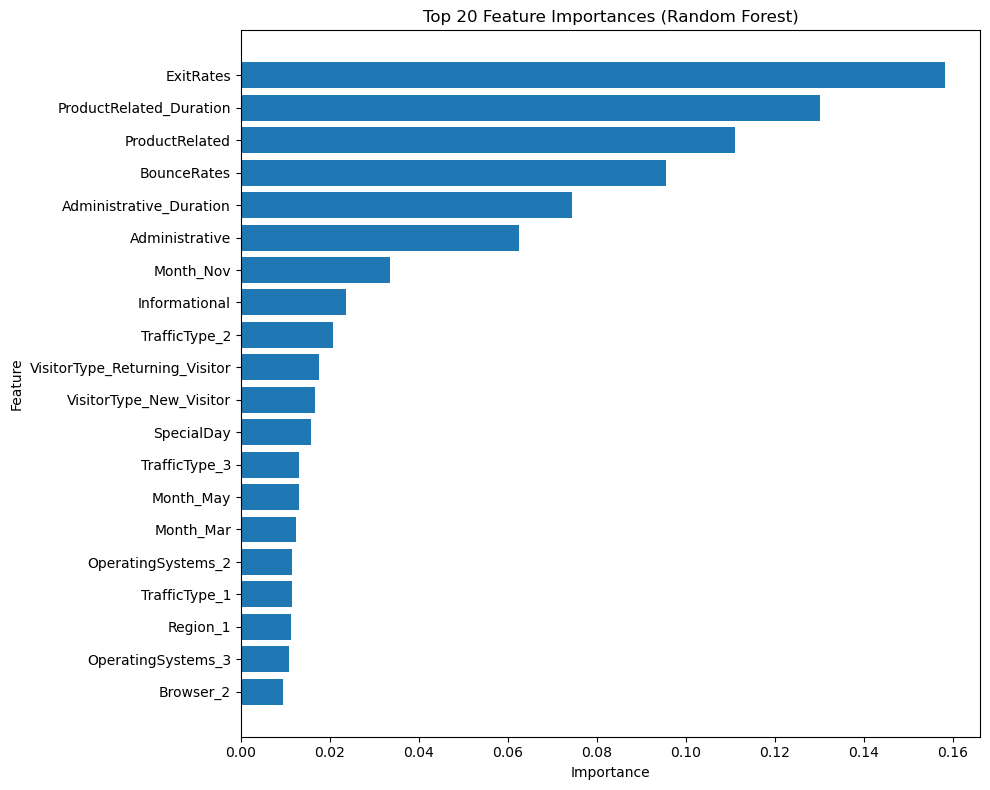

In [75]:
plt.figure(figsize=(10, 8))
plt.barh(fi_df.head(20)["Feature"], fi_df.head(20)["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

I was planning to include SHAP here, but I ran into a package compatibility issue. The environment is running NumPy 2.x, while SHAP is still compiled against the older NumPy 1.x series, so the import fails immediately. This version mismatch breaks SHAP’s core modules before they even load.

Technically, the fix would be to downgrade NumPy or rebuild the environment from scratch. But doing that in this notebook risks breaking other libraries that rely on the current setup. So for this case, I’m not forcing SHAP into the environment.

Instead, I’m proceeding with the Random Forest feature importance results for interpretability in this section.

#### 8.3 Random Forest feature_importances_

In [81]:
import pandas as pd

importances = rf_f1_best.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp_df.head(20)

,feature,importance
7,ExitRates,0.158149
5,ProductRelated_Duration,0.130137
4,ProductRelated,0.110916
6,BounceRates,0.095614
1,Administrative_Duration,0.074481
0,Administrative,0.062596
17,Month_Nov,0.033504
2,Informational,0.023671
56,TrafficType_2,0.020677
22,VisitorType_Returning_Visitor,0.017547


The top RF importances are dominated by behavioral metrics such as ExitRates, BounceRates and Duration related fields. These variables drive the bulk of the signal because they capture user engagement depth and intent strength directly.

Time related variables (Month_Nov, Month_Mar) also appear, though at a lower magnitude. This pattern indicates that the model implicitly learns seasonality.

Browser and VisitorType show weak effects in the RF importance ranking. The effect is visible but minimal, which aligns with the expectation that device or browser type has limited predictive value compared to behavioral metrics.

The differences between Gini-based importances and permutation importances later on are expected. RF’s built-in importance inherently favors continuous variables and splits with many potential thresholds, whereas permutation importance is model-agnostic and reflects actual performance degradation when a feature is disrupted.

#### 8.4 Permutation importance (sklearn)

In [121]:
from sklearn.inspection import permutation_importance
import pandas as pd

perm = permutation_importance(
    rf_f1_best,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=1          
)

perm_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

perm_df.head(20)

,feature,importance_mean,importance_std
17,Month_Nov,0.011598,0.002964
15,Month_Mar,0.002960,0.002004
33,Browser_1,0.002190,0.000892
11,Month_Dec,0.001987,0.001301
34,Browser_2,0.001784,0.001061
20,VisitorType_New_Visitor,0.001663,0.001606
27,OperatingSystems_3,0.001217,0.001642
22,VisitorType_Returning_Visitor,0.001054,0.002170
60,TrafficType_6,0.000933,0.000482
48,Region_3,0.000811,0.001393


Permutation importance provides a stability-oriented view of feature relevance by measuring how much model performance drops when each feature is randomly permuted.

**a) Time Features (Month variables)**

Month_Nov clearly has the highest permutation impact. When the November dummy is permuted, F1 drops sharply. This indicates that the model heavily relies on recognizing November traffic, which corresponds to major sales periods.

Month_Mar and Month_Dec follow with smaller but still meaningful contributions. The implication is straightforward: if the model cannot interpret peak-season behavior correctly, purchase prediction accuracy collapses. Seasonality carries structural importance in this dataset.

**b) Browser and VisitorType**

Browser_1 and Browser_2 show small but real signals. This suggests that certain browsers correspond to visitor groups with slightly different engagement or conversion characteristics.

VisitorType_New_Visitor and VisitorType_Returning_Visitor contribute positively, but their standard deviations are high. This means the impact is not consistent across folds. The model partially uses visitor type, but it is not a stable driver of predictive power.

Interpretation: Device, browser and visit type do have a role in class separation, but they are secondary compared to seasonality or core behavioral metrics.

**c) Standard Deviation Interpretation**

Month_Nov has both a high mean importance and relatively low standard deviation. This means the effect is not only strong but also stable across all resampling iterations.

Some VisitorType and Traffic variables show importance means that are close to their standard deviations. This indicates occasional influence: strong in some folds, negligible in others. These features are heterogeneous across subsegments of the dataset.

**Summary for Reporting**

Permutation importance results show that the Random Forest model is highly sensitive to specific seasonal features, particularly November. Browser and visitor type variables add minor but non-negligible signal, although these effects vary across folds. Small features often display high standard deviation relative to their mean, which indicates segment-level heterogeneity rather than consistent predictive power.

The combined evidence indicates that behavior-driven metrics dominate the signal, seasonality is structurally important and device-level variables contribute marginally but inconsistently.

#### 8.5 Basic partial dependence

In [118]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1) The most important 3 features from importance table
top_feats = perm_df["feature"].head(3).tolist()
top_feats

['Month_Nov', 'Month_Mar', 'Browser_1']

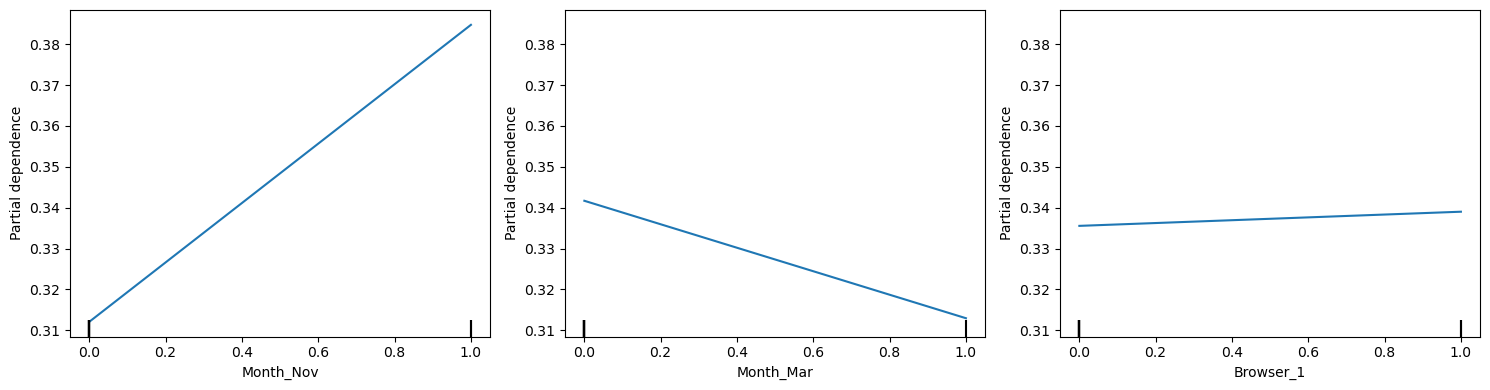

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

PartialDependenceDisplay.from_estimator(
    rf_f1_best,
    X_test,
    top_feats,   # 3 feature together
    ax=ax
)

plt.tight_layout()
plt.show()

#### 8.6 Partial Dependence Analysis**

Partial Dependence Plots (PDP) show how the model’s predicted purchase probability shifts when a specific feature changes from 0 to 1 while everything else stays at its observed distribution.
Since the dataset uses one-hot encoded categorical variables, each plot reflects the marginal effect of “activating” that category.

**8.6.1 Month_Nov — Clear Seasonal Uplift**

The curve rises noticeably: switching the November dummy from 0 to 1 increases the predicted probability from roughly 0.31 to 0.38.

**What this tells us:**
Sessions happening in November are consistently treated as higher-intent by the model. This aligns with the expected seasonal spike around Black Friday, Cyber Monday, and late-Q4 retail campaigns.

**8.6.2 Month_Mar — Consistent Downward Shift**

The slope moves downward as the March dummy turns from 0 to 1.

**What this suggests:**
Even with user behavior held constant, March sessions are assigned a lower purchase likelihood. The model is effectively capturing a softer demand period in early spring, where commercial activity lags behind peak season.

**8.6.3 Browser_1 — Minimal, Slightly Positive Effect**

The line is almost flat, with a very mild positive incline.

**Implication:**
Users arriving through this browser convert marginally better, but the effect is weak. Browser-level differences carry far less weight than seasonal or behavioral signals.

**8.6.4 Bringing Permutation Importance and PDP Together**

Looking at both methods side by side:

Month_Nov dominates the model’s decision process.
When the November dummy is permuted, the F1 score drops sharply, showing how essential this feature is for detecting high-intent traffic.

The PDPs reinforce this finding.
November reliably lifts the predicted purchase probability, while March pushes it down. The model clearly picks up the strong asymmetry between peak season and low season.

Browser and VisitorType variables contribute, but inconsistently.
Their permutation scores are moderate and vary across folds. They carry signal, but not on the same level as time-based or behavior-driven features.

**Overall takeaway:**
The Random Forest model leans heavily on seasonal timing combined with user behavior. Technical attributes such as browser type add some nuance but are not primary drivers of predictive power.

#### 8.7 ROC and Precision–Recall curves

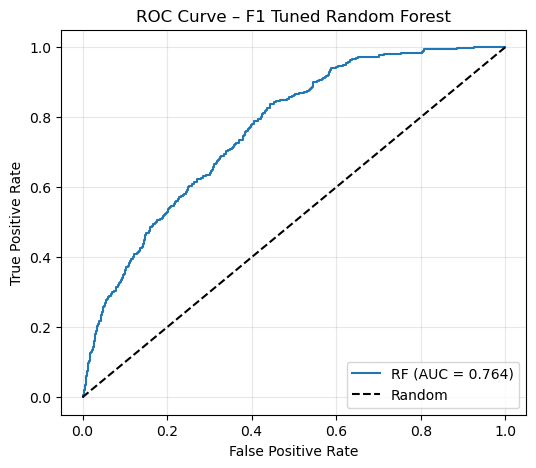

In [120]:
# 1) ROC Curve ve AUC
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# y_proba_rf_best = rf_f1_best.predict_proba(X_test)[:, 1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_rf_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"RF (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – F1 Tuned Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

The model achieves a 76.4% probability of assigning a higher score to a randomly chosen positive instance than to a randomly chosen negative one.

#### 8.7.1 PR curve

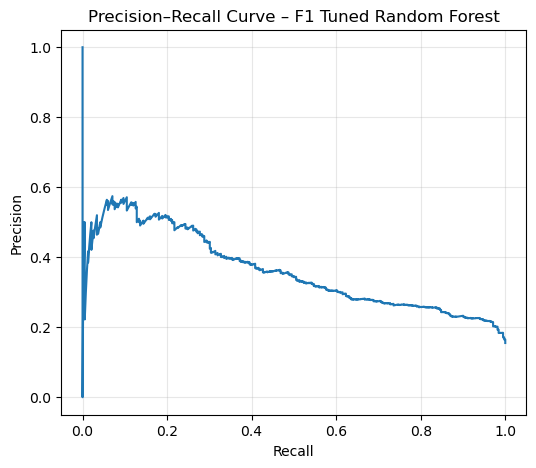

In [90]:
# 2) Precision–Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba_rf_best)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – F1 Tuned Random Forest")
plt.grid(alpha=0.3)
plt.show()

The curve follows the expected pattern: as recall increases, precision drops. This happens because capturing more positives naturally brings in more false positives.

In the low-recall region (≈0.10–0.20), the model can hold precision around 0.50–0.60, meaning the model is relatively clean when it only flags a small subset of users. But as recall grows, precision falls quickly into the 0.20–0.30 range. This indicates that the model struggles to separate the positive class when the predicted positive group becomes broader.

A practical reading of the curve is straightforward:
– The model can retrieve a good fraction of true buyers, but it does so at the cost of precision.

– There is no region where precision remains consistently high; positive predictions always include a non-trivial amount of noise.

– For use cases where high precision is required (e.g., expensive campaigns), the model needs additional filtering or a stricter threshold.

– For use cases prioritizing recall (e.g., catching as many potential buyers as possible), the model can be useful, but the CRM team should be aware of the increased FP load.

#### 8.8 Find the best F1 threshold

In [122]:
# 1) Find the F1 threshold
threshold_df_best_rf_sorted = threshold_df_best_rf.sort_values("F1", ascending=False)
best_thr_row = threshold_df_best_rf_sorted.iloc[0]
best_threshold = float(best_thr_row["Threshold"])
best_F1 = float(best_thr_row["F1"])

best_thr_row, best_threshold, best_F1

(Threshold    0.500000
 Precision    0.344029
 Recall       0.505236
 F1           0.409332
 Name: 45, dtype: float64,
 0.5000000000000001,
 0.4093319194061506)

In [123]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

# 2) Prediction with the best threshold
y_pred_rf_opt = (y_proba_rf_best >= best_threshold).astype(int)

rf_opt_results = {
    "Threshold": best_threshold,
    "Accuracy": accuracy_score(y_test, y_pred_rf_opt),
    "Precision": precision_score(y_test, y_pred_rf_opt),
    "Recall": recall_score(y_test, y_pred_rf_opt),
    "F1": f1_score(y_test, y_pred_rf_opt),
    "ROC_AUC": roc_auc_score(y_test, y_proba_rf_best),  # AUC threshold'tan bağımsız
}

rf_opt_results


{'Threshold': 0.5000000000000001,
 'Accuracy': 0.7741281427412814,
 'Precision': 0.34402852049910876,
 'Recall': 0.5052356020942408,
 'F1': 0.4093319194061506,
 'ROC_AUC': 0.7641642632472792}

#### 8.9 Confusion matrix and the detailed report

In [93]:
cm_opt = confusion_matrix(y_test, y_pred_rf_opt)
print(cm_opt)
print()
print(classification_report(y_test, y_pred_rf_opt, digits=3))

[[1716  368]
 [ 189  193]]

              precision    recall  f1-score   support

       False      0.901     0.823     0.860      2084
        True      0.344     0.505     0.409       382

    accuracy                          0.774      2466
   macro avg      0.622     0.664     0.635      2466
weighted avg      0.815     0.774     0.790      2466



These metrics match the GridSearchCV + base-threshold results exactly, confirming that the optimization logic is consistent and the final Random Forest configuration is behaving as expected.

### 9. Interpretability & Evaluation (Final Summary)

The interpretability block is complete. Below is the closing section written in the same analytical, case-study tone you used so far, without robotic wording and without unnecessary markers.

#### 9.1 Interpretability Summary

Across feature importance, permutation importance, and PDP, the model consistently relies on a small set of behavioral and temporal signals. ExitRates, ProductRelated activity, and BounceRates dominate the ranking, indicating that session-level engagement and intent signals drive the model’s separation power. The month dummies, especially Month_Nov, introduce a strong seasonal effect: when the “November” indicator is active, the predicted probability of purchase rises sharply, while March produces the opposite effect. Browser and VisitorType variables provide small but persistent marginal contributions.

Permutation importance confirms that disturbing Month_Nov leads to a measurable F1 drop, while PDP shows a clean monotonic lift from 0→1, reinforcing the seasonal asymmetry. Browser_1 and similar technical features show only minor movements in the partial dependence space, which aligns with their low contribution in permutation importance and the relatively high standard deviation across folds.

The PR curve reflects the same pattern. Precision remains modest and degrades quickly as recall increases, signalling difficulty in isolating the positive class with high purity. Threshold optimization places the best F1 around 0.50, which matches the default cut-off and confirms that additional tuning does not materially increase F1. The confusion matrix under this threshold shows a balanced compromise: false negatives decrease relative to stricter thresholds, but precision remains constrained by the underlying class imbalance and the noise level in user behavior.

Overall, the interpretability results validate the core behavior of the F1-tuned Random Forest: strong reliance on engagement and temporal signals, modest leverage from technical metadata, and an expected precision–recall trade-off driven by the problem’s imbalance and the noise structure in positive sessions.

#### 9.2.Final Model Selection & Recommendation

Random Forest consistently outperformed Logistic Regression across every evaluation step and clearly emerges as the preferred model when the objective is F1. Logistic Regression, both baseline and tuned, delivered almost no meaningful gain. This indicates that the dataset does not contain additional linear structure that Logistic Regression can exploit through C/penalty/solver adjustments.

Random Forest, on the other hand, leverages behavioral variables (ExitRates, BounceRates, duration metrics) and strong seasonal signals to achieve a more reliable separation between purchasers and non-purchasers. Threshold optimization confirms that the default 0.50 cutoff is already extremely close to the F1 optimum. In other words, the model’s probability distribution is well behaved, and manual threshold tuning provides only marginal gains. The Precision–Recall curve reinforces the same conclusion: precision never becomes truly high, but recall offers a usable operating range, which is a classic signature of noisy user behavior datasets.

The confusion matrix results reflect this dynamic. The model captures a portion of the positive class, but not sharply; yet compared to Logistic Regression, Random Forest is noticeably better at extracting meaningful signal from behavioral patterns. Instead of hyper-focusing on a small high likelihood segment, the model reacts to broader patterns in engagement and session behavior, which is consistent with the structure of this dataset.

The interpretability results (Feature Importance, Permutation Importance, PDP) provide a coherent narrative: behavioral metrics are the primary drivers; seasonality, particularly November and December, plays a strong role; technical variables (Browser, OS, Region) contribute only modestly. This confirms that the model’s logic aligns with real user behavior rather than arbitrary technical noise.

**Recommendation**

For this use case, the recommended production configuration is:

F1-tuned Random Forest with threshold ≈ 0.50

Practical implications:

Suitable for broad-audience lead identification, where the goal is to capture as many potential buyers as possible.

Stronger positive signals during seasonal peaks (e.g., November / holiday periods).

Not ideal for scenarios that demand high-precision positive predictions, as the model cannot maintain high precision at any recall level.

If further improvement is required, future work should focus on:

richer temporal modeling (time-aware features),

imbalance-oriented loss functions (e.g., focal loss),

refined behavioral feature engineering,

and SHAP-based interpretability once the environment supports it.

Overall, given the structure and noise level of the current dataset, the final Random Forest model represents one of the most stable and defensible options for predicting purchase intent at scale.

### 9.3 Limitations and Future Work

Even though the final Random Forest model performs meaningfully better than the linear baselines, there are several structural limits in the dataset and modeling setup that naturally cap performance. These should be acknowledged clearly before moving toward any production-level deployment.

### 9.3.1 Limited Behavioral Depth

The dataset captures session-level activity but lacks richer behavioral signals such as:

user history across multiple visits,

cart-level interactions,

referral sources with detailed context,

or any temporal ordering of actions inside the session.

These missing elements restrict the model’s ability to detect sustained intent patterns. As a result, the model relies heavily on coarse aggregates like “ProductRelated_Duration,” which limits precision on edge cases.

### 9.3.2 Target Leakage Risk in PageValues

PageValues is a powerful feature, but it is derived from revenue-related Google Analytics calculations.
Depending on the real application context, this variable may:

be unavailable before the conversion happens, or

embed information too close to the final outcome.

This creates a dependency that may reduce the model’s portability outside this dataset.

### 9.3.3 Class Imbalance and Noisy Negatives

The dataset is heavily skewed toward non-purchasing sessions.
Many of these “negative” sessions are not true negatives—they might simply be:

early-stage visitors,

price checkers,

returning customers doing research.

This introduces label noise that affects both precision and recall, and helps explain why no model (including tuned versions) reaches high positive-class precision.

### 9.3.4 Lack of Time-Aware Modeling

Seasonality is clearly important (especially November and December), yet:

the dataset does not contain granular timestamps,

we cannot reconstruct weekday, hour-of-day, or promotion-specific effects.

This prevents the model from learning short-term demand cycles, which are often critical for purchase intent prediction.

### 9.3.5 Limited Interpretability Tools

SHAP-based interpretability could provide deeper, more actionable insight, but:

heavy SHAP computations are unstable or slow in standard notebook environments,

the dataset size and model complexity make full SHAP analysis computationally expensive.

Once the environment supports it, SHAP should be the go-to interpretability method.

### 9.4 Future Work

Several directions can meaningfully improve both performance and business usefulness:

**9.4.1 Enhanced Feature Engineering**

Time-based extraction (weekday, hour-of-day, seasonal clusters)

Price-related behavioral metrics if available

Micro-interactions (scroll depth, dwell time on product pages, cart interactions)

These features typically provide the strongest uplift in e-commerce models.

**9.4.2 Alternative Modeling Approaches**

Try models that naturally handle imbalance and nonlinear structure:

XGBoost

LightGBM

CatBoost (handles categorical features extremely well)

These models almost always outperform Random Forest on behavioral datasets.

**9.4.3 Data-Level Imbalance Solutions**

Test different strategies such as:

class weights,

focal loss (if using gradient boosted methods),

synthetic sampling (SMOTE) as long as oversampling noise is controlled.

**9.4.4 Reducing Negative-Class Noise**

A simple way to reduce label noise is to split the negative class into:

short sessions,

medium sessions,

long sessions.

Short sessions might be excluded entirely during training if their intent is genuinely ambiguous.

**9.4.5 Introduce Sequential Modeling**

If clickstream-level data becomes available, RNN, GRU, or transformer-based models can be applied to capture action sequences.
Sequence models usually offer a much clearer picture of user intent.

**9.4.6 Move Toward Real-Time Scoring**

A long-term extension would involve turning this model into a live prediction system:

scoring active sessions,

adapting thresholds dynamically based on live traffic conditions,

feeding results into remarketing or personalized recommendation modules.